## Importing Libraries and Datasets

In [93]:
import pandas as pd
import numpy as np
import json
import ast
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [94]:
df = pd.read_csv('crm_activities_100_voc.csv')

In [95]:
df.rename(columns={
    "POTENTIALID": "deal_id",
    "ACTIVITY_TIMESTAMP": "timestamp",
    "ACTIVITY": "activity_type",
    "CONTACTID": "contact_id",
    "ACCOUNTID": "account_id",
    "CALL_VOC": "call_voc",
    "EMAIL_VOC": "email_voc",
    "EVENT_VOC": "event_voc",
    "INVOICE_VOC": "invoice_voc",
    "QUOTE_VOC": "quote_voc",
    "SALESORDER_VOC": "salesorder_voc",
    "DEALSTAGE": "deal_stage",
    "CLASS_TAG": "class_tag",
    "INVOICEGRANDTOTAL": "deal_amount",
}, inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

## Extracting values of VOC columns

In [96]:
# Mapping activity_type to corresponding voc column
voc_mapping = {
    'mail': 'email_voc',
    'call': 'call_voc',
    'meeting': 'event_voc',
    'quote': 'quote_voc',
    'salesorder': 'salesorder_voc',
    'invoice': 'invoice_voc'
}

# Function to get voc dict based on activity_type
def extract_voc(row):
    voc_col = voc_mapping.get(row['activity_type'])
    voc_data = row[voc_col]
    if pd.isna(voc_data):
        return None
    if isinstance(voc_data, str):
        try:
            voc_data = ast.literal_eval(voc_data)  # convert string dict to actual dict
        except Exception:
            return None
    return voc_data if isinstance(voc_data, dict) else None

# Extract into separate columns
df['voc_dict'] = df.apply(extract_voc, axis=1)
df['sentiment'] = df['voc_dict'].apply(lambda x: x.get('sentiment') if isinstance(x, dict) else None)
df['intent'] = df['voc_dict'].apply(lambda x: x.get('intent') if isinstance(x, dict) else None)
df['emotion'] = df['voc_dict'].apply(lambda x: x.get('emotion') if isinstance(x, dict) else None)

# Drop temp column if not needed
df.drop(columns=['voc_dict'], inplace=True)

## Mapping VOC columns as numerics

In [97]:
sentiment_map = {"positive": 1, "neutral": 0.5, "negative": 0.2}
intent_map = {
    "purchase": 1.0, "gratitude": 0.9, "request": 0.8, "query": 0.6,
    "complaint": 0.2, "others": 0.3
}
emotion_map = {
    "happy": 1.0, "gratitude": 0.9, "trust": 0.9,
    "neutral": 0.5, "confusion": 0.3, "frustration": 0.2, "discontentment": 0.2
}

df["sentiment_score"] = df["sentiment"].map(sentiment_map)
df["intent_score"] = df["intent"].map(intent_map)
df["emotion_score"] = df["emotion"].map(emotion_map)

## Plot contact behaviour trends

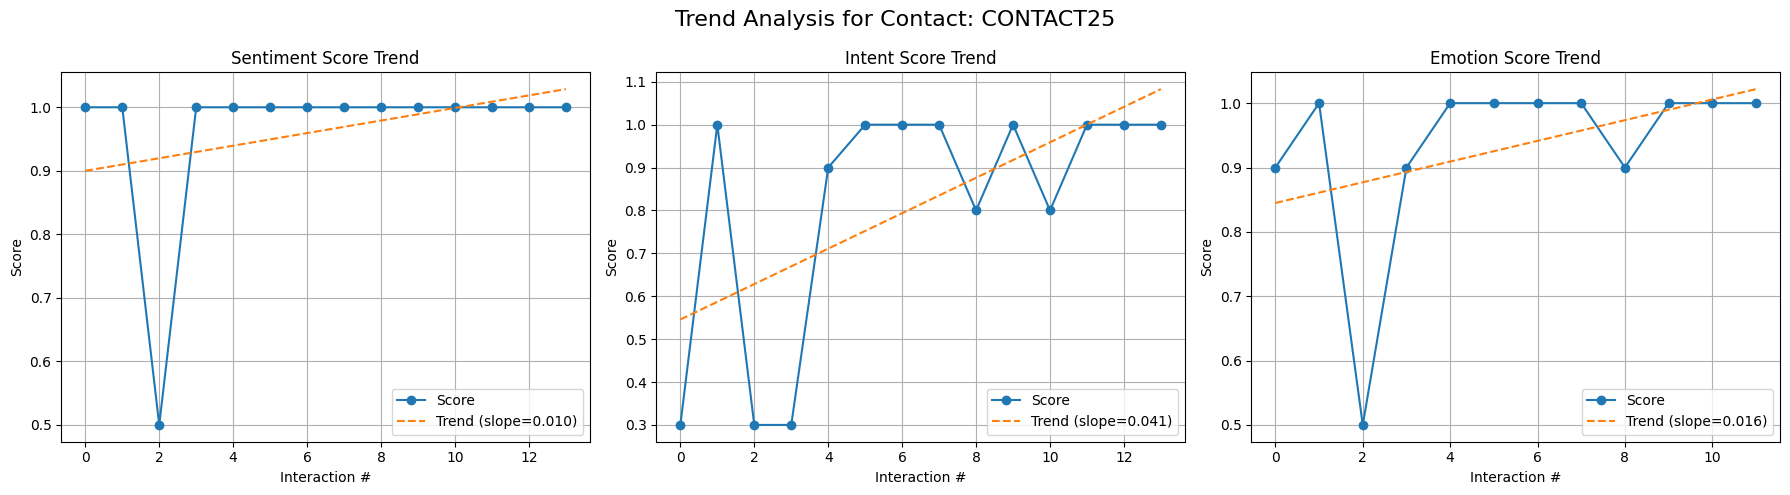

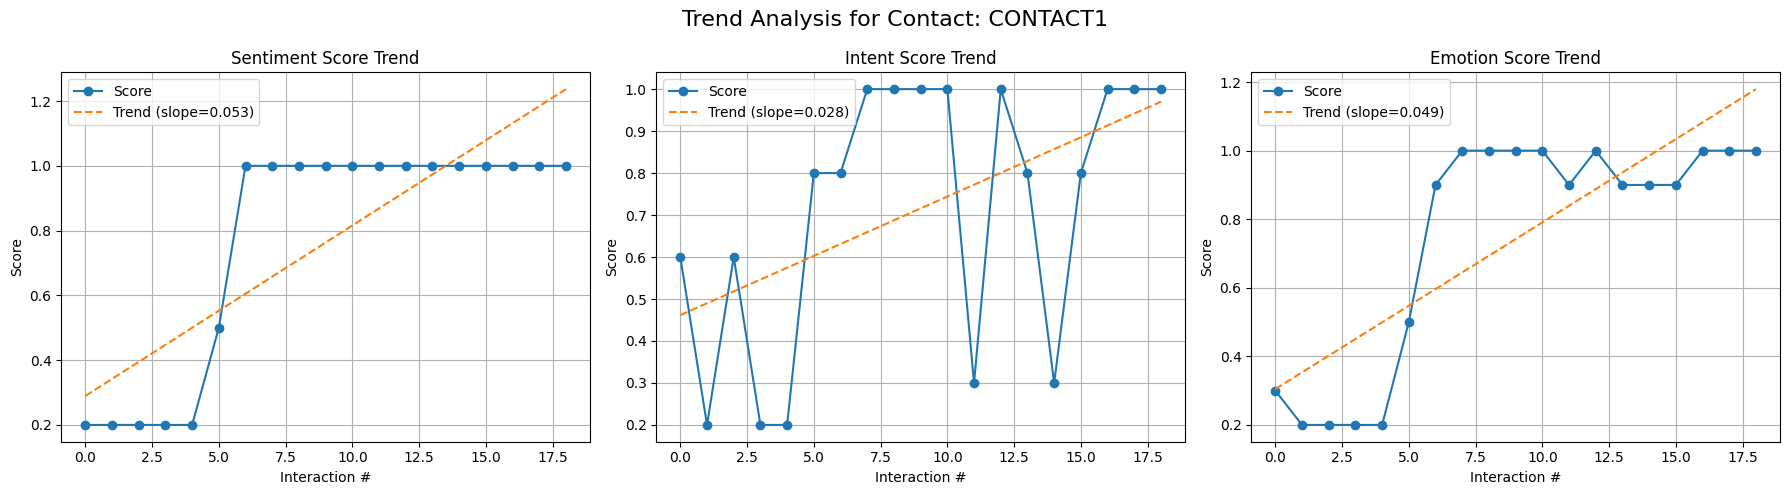

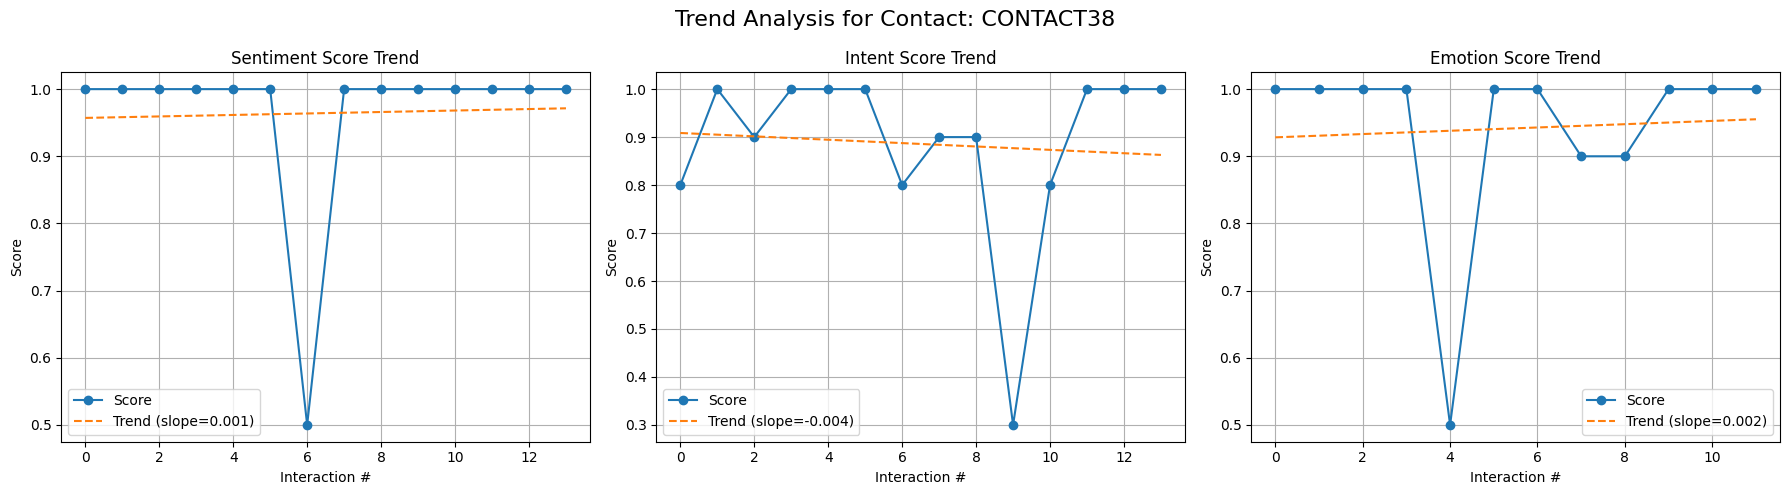

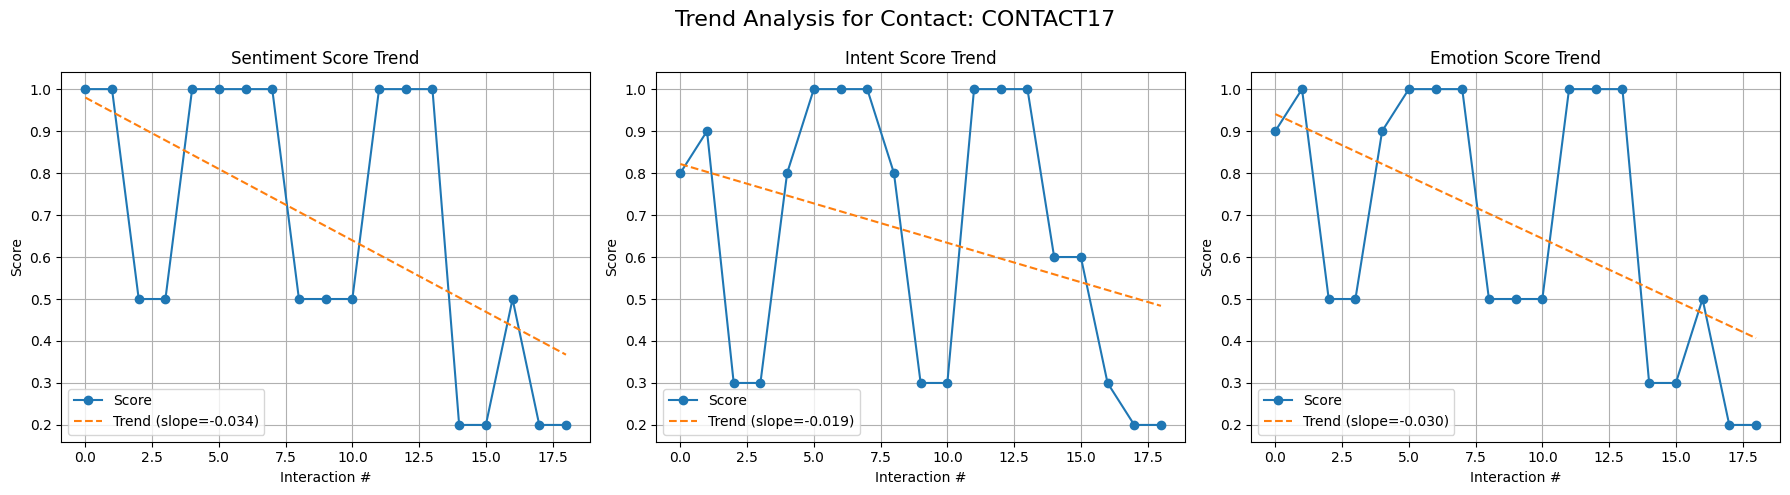

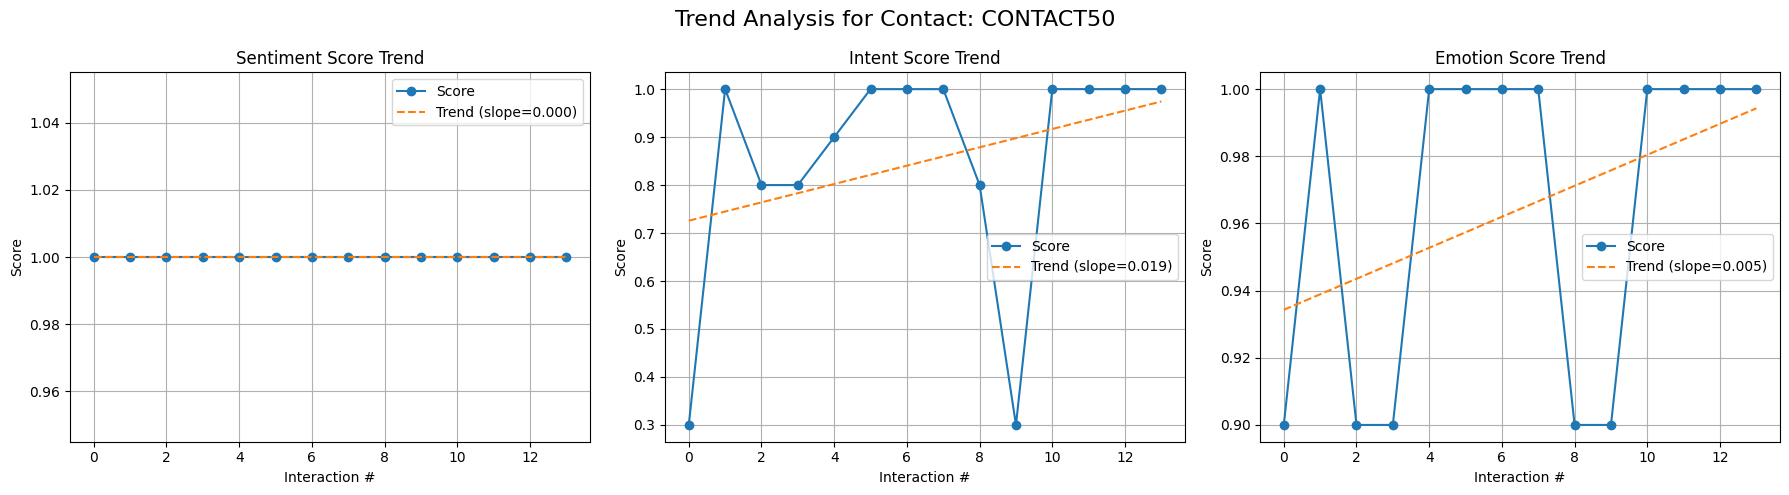

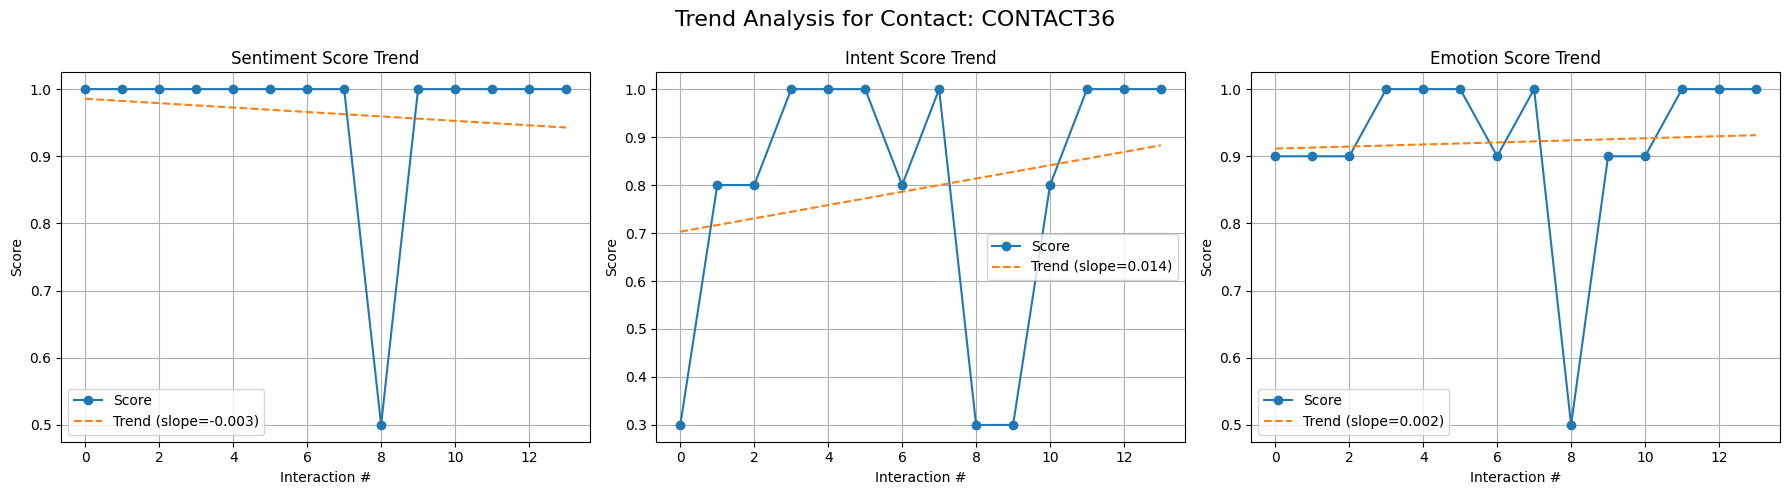

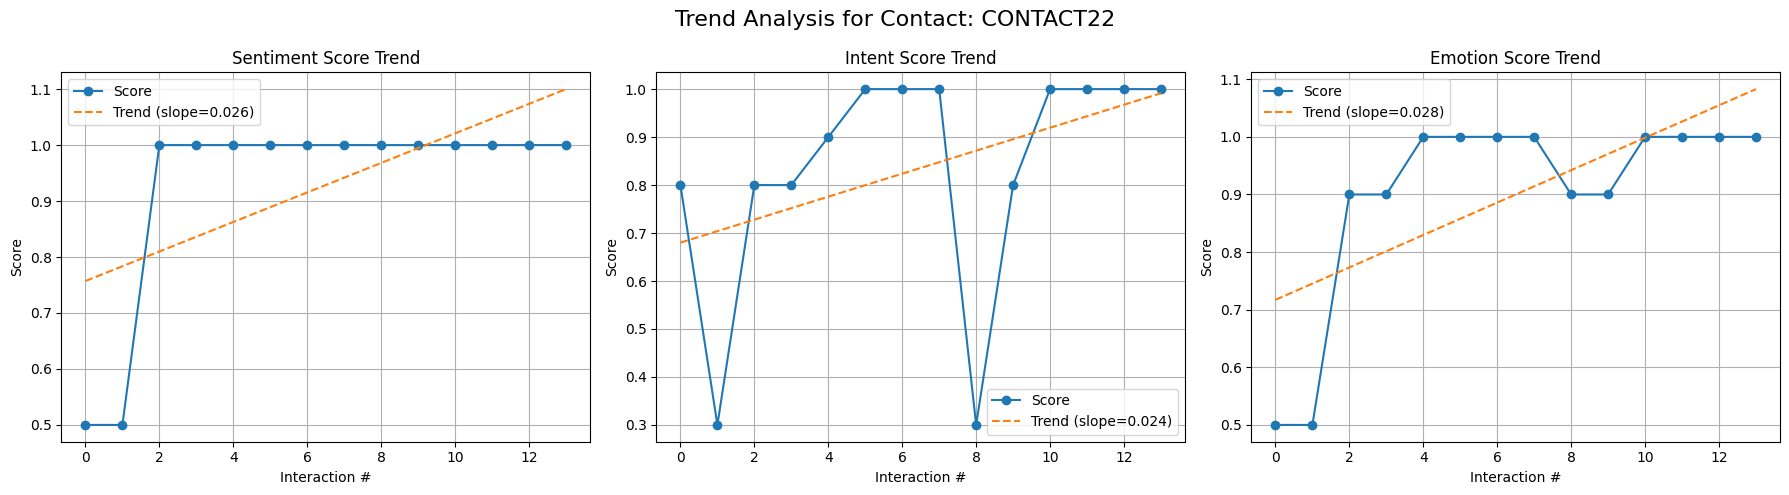

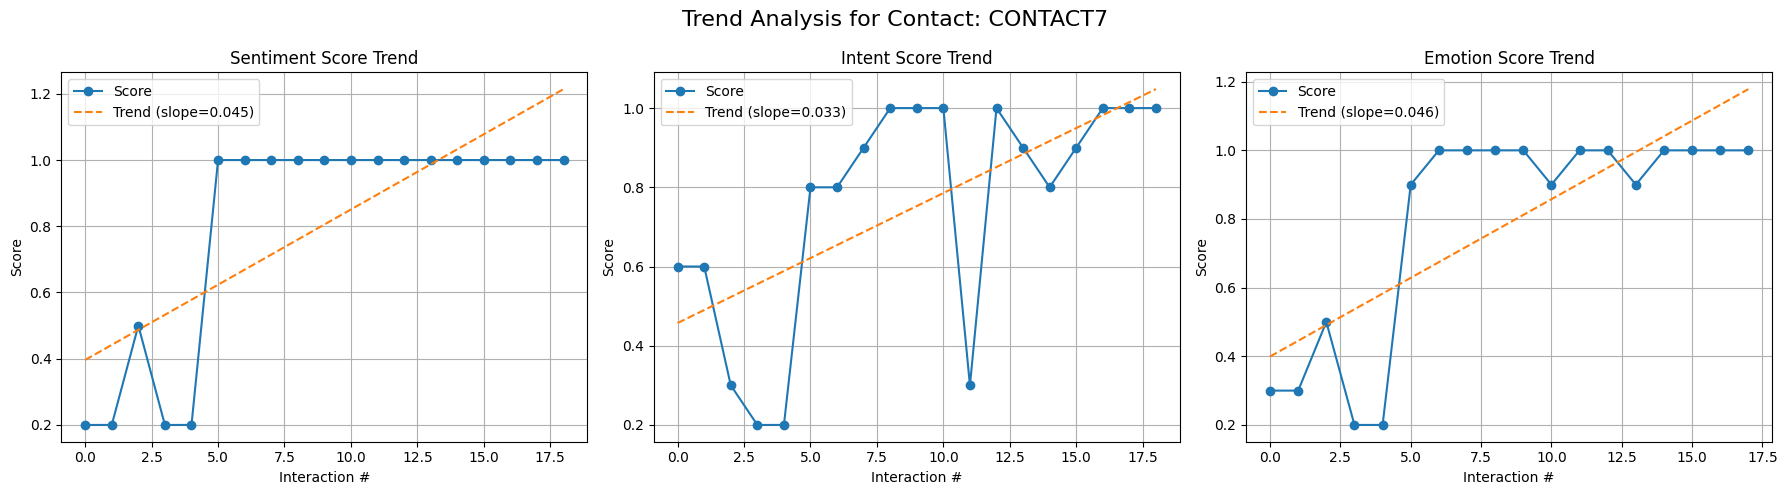

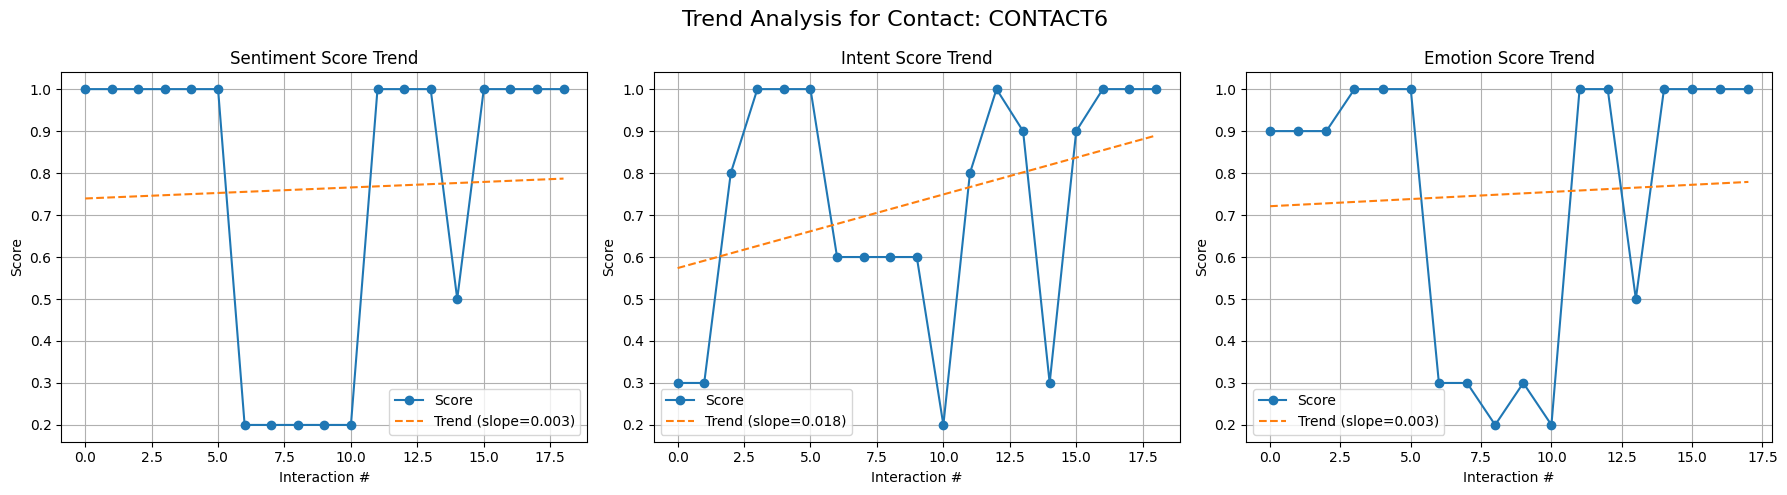

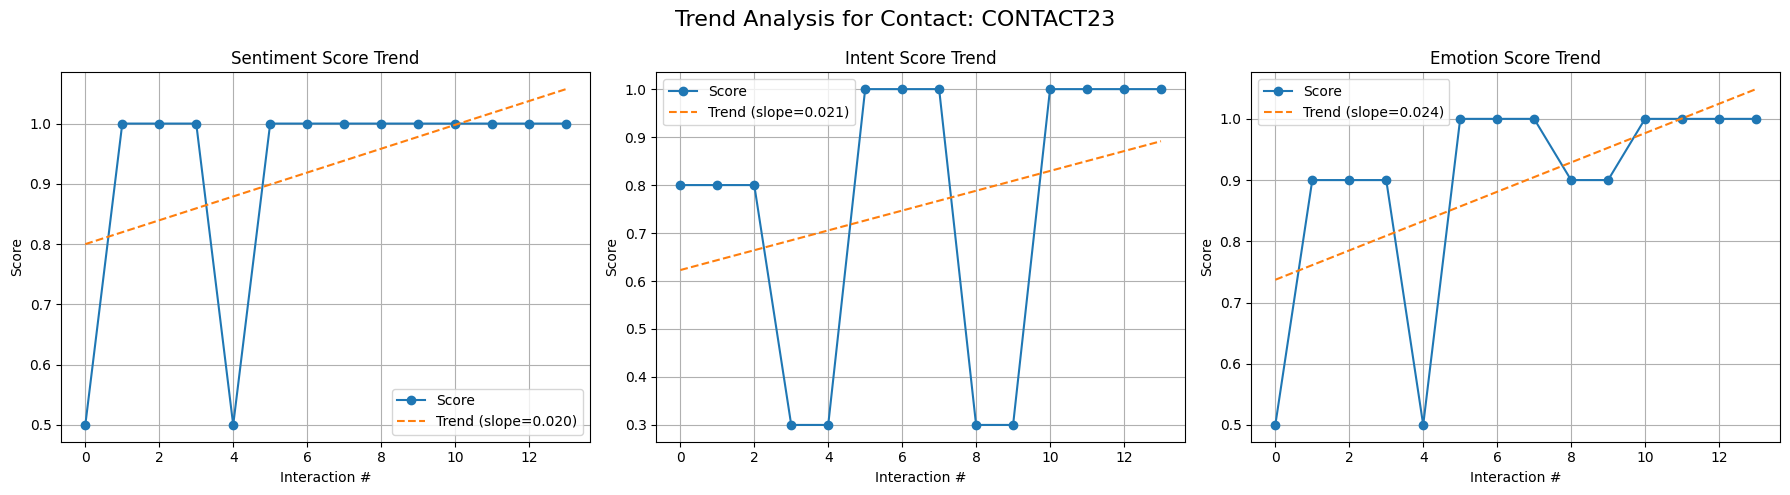

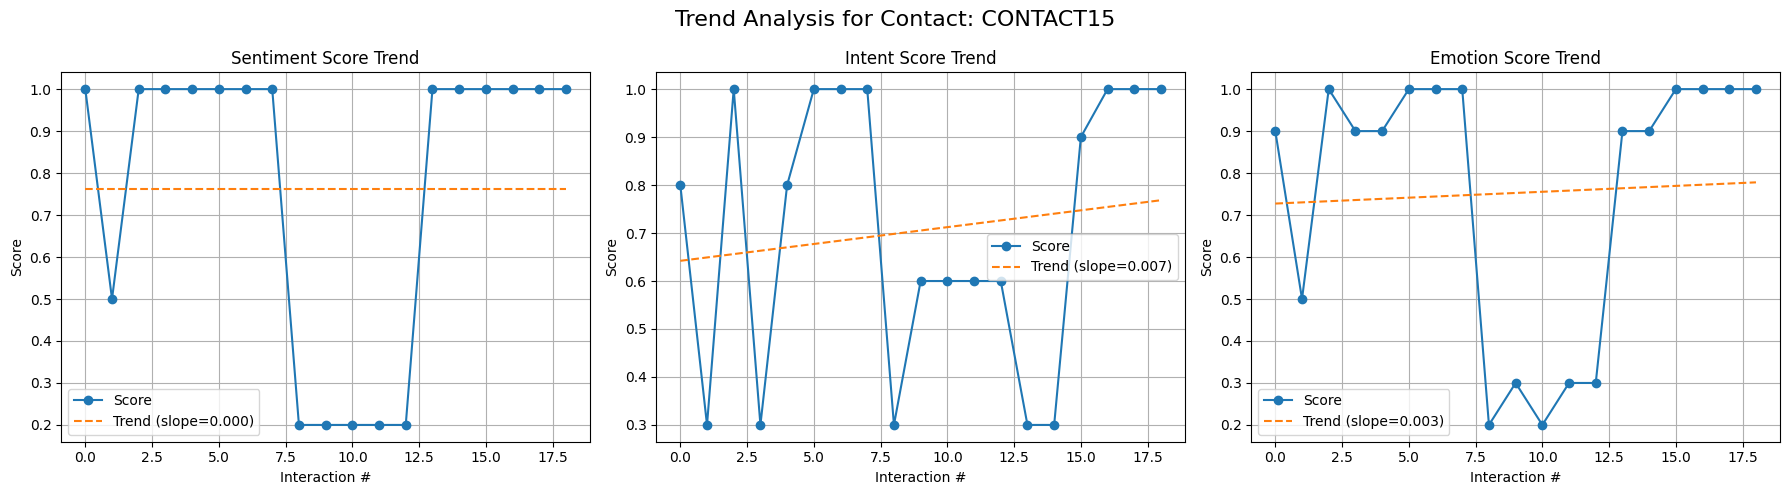

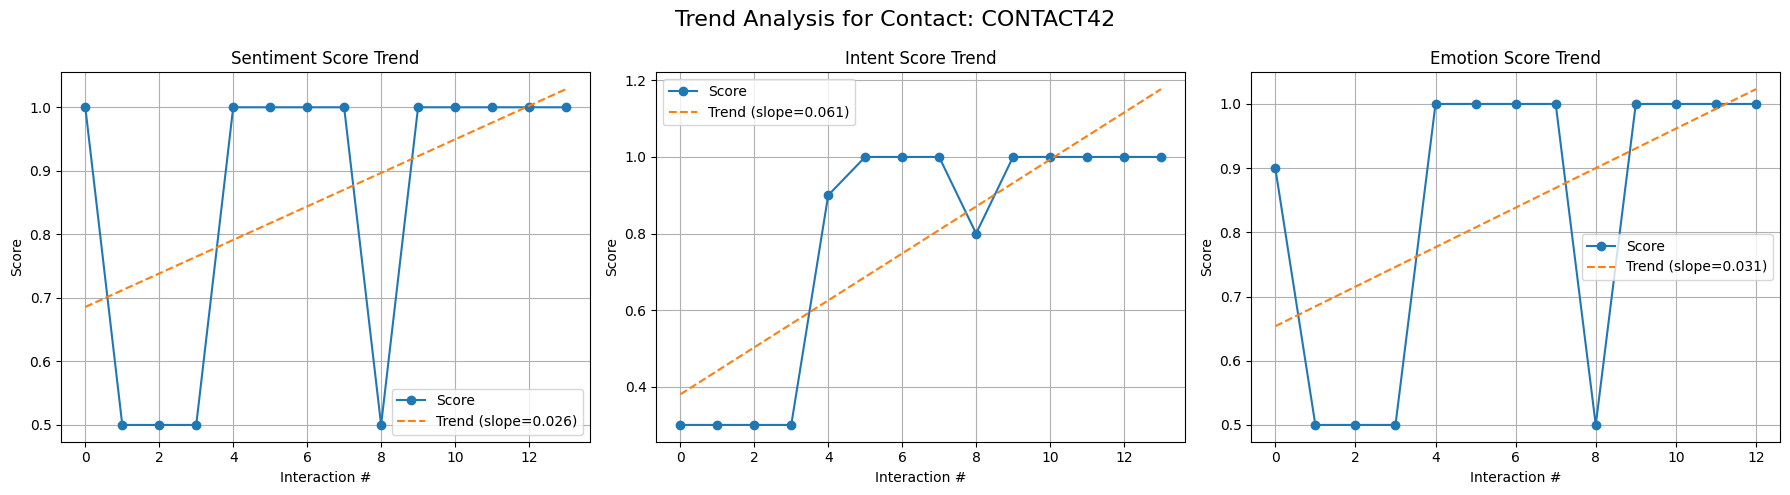

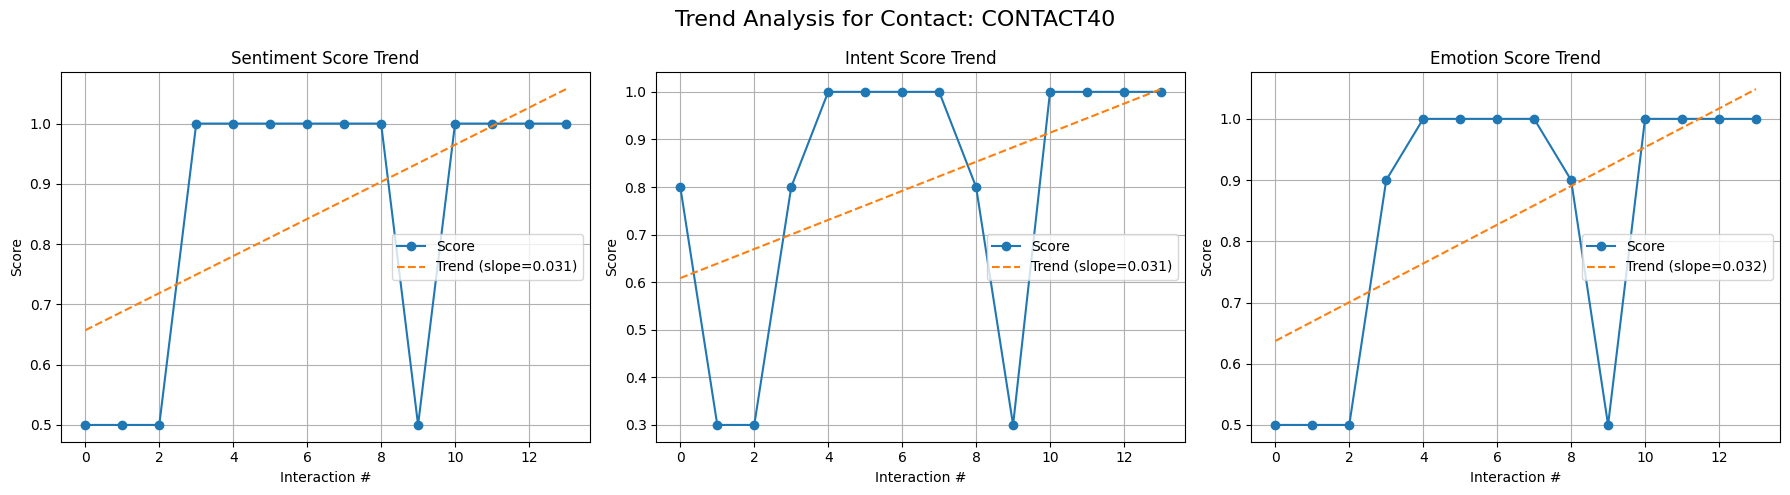

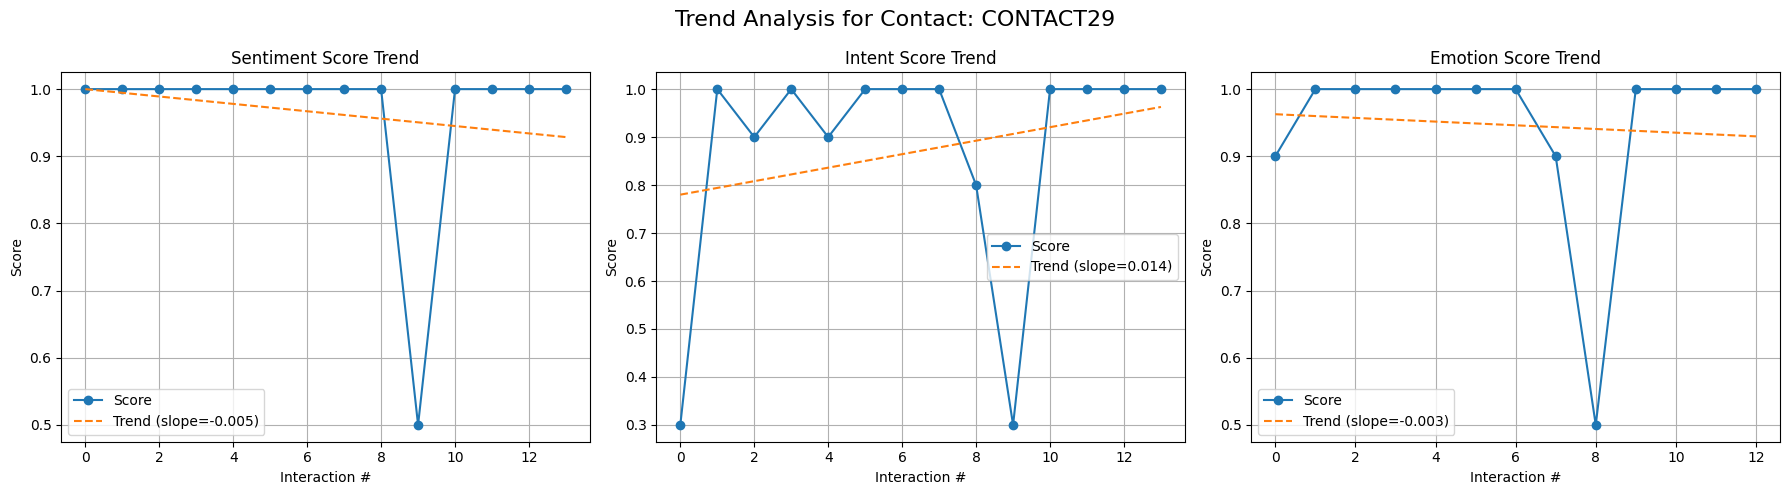

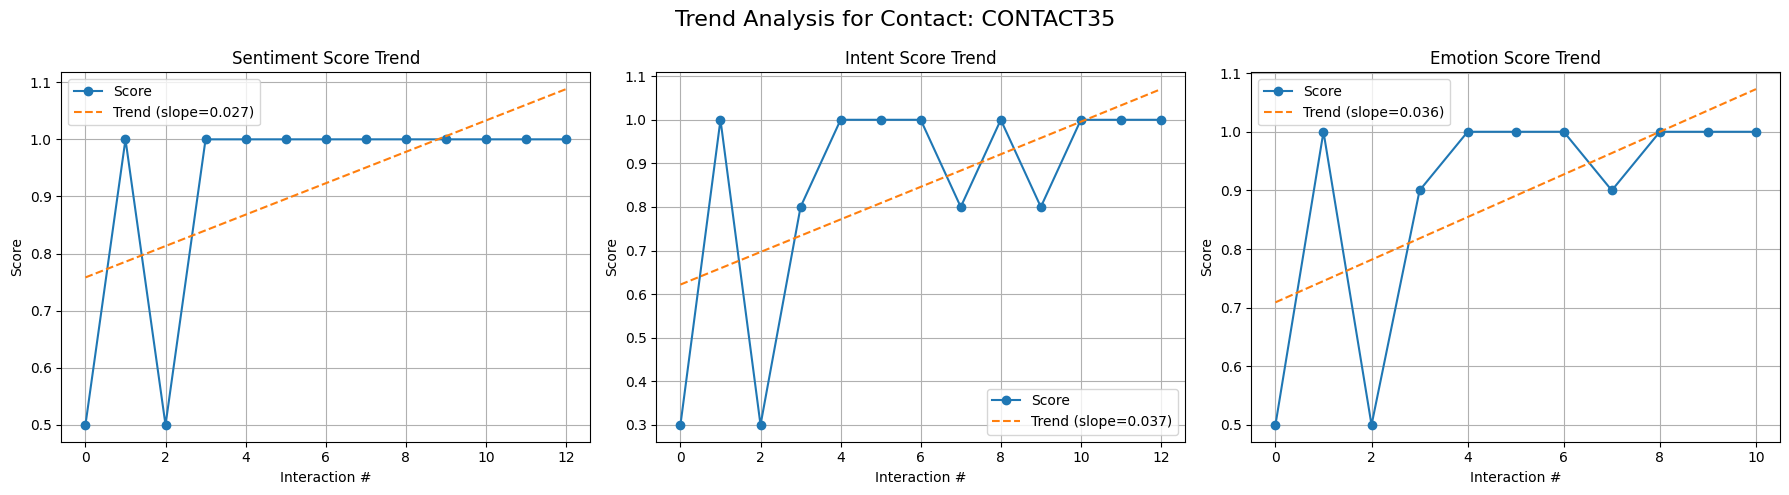

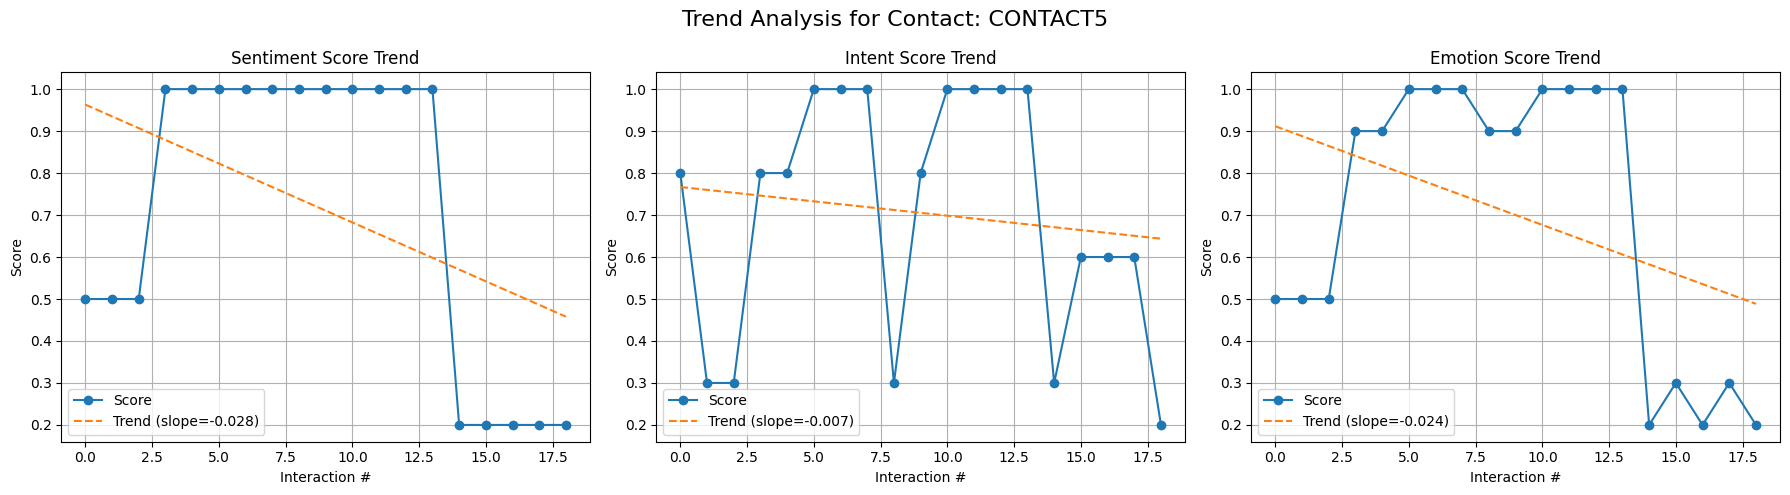

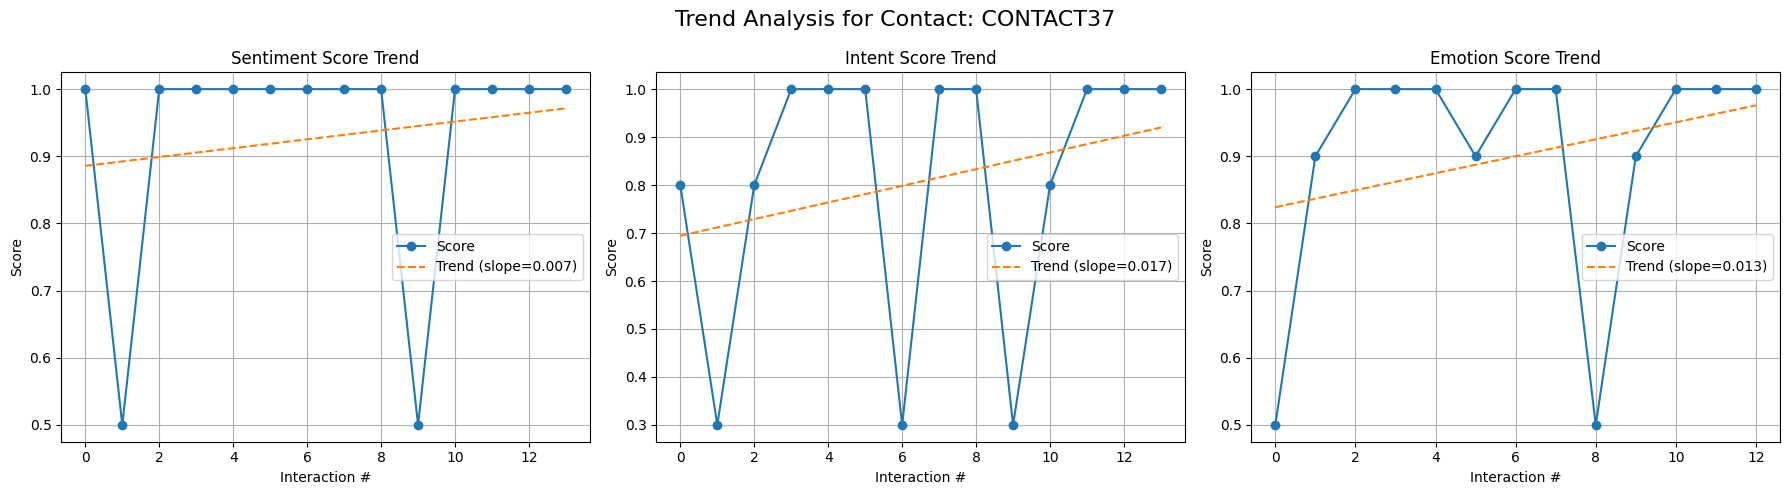

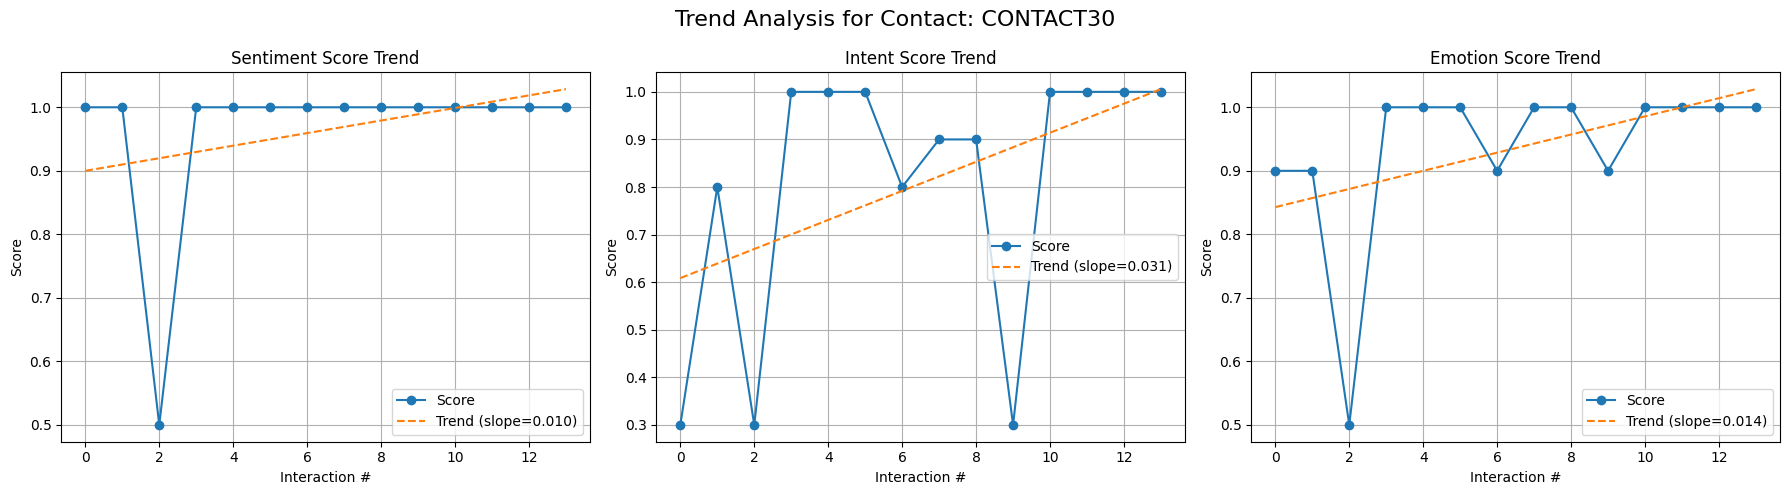

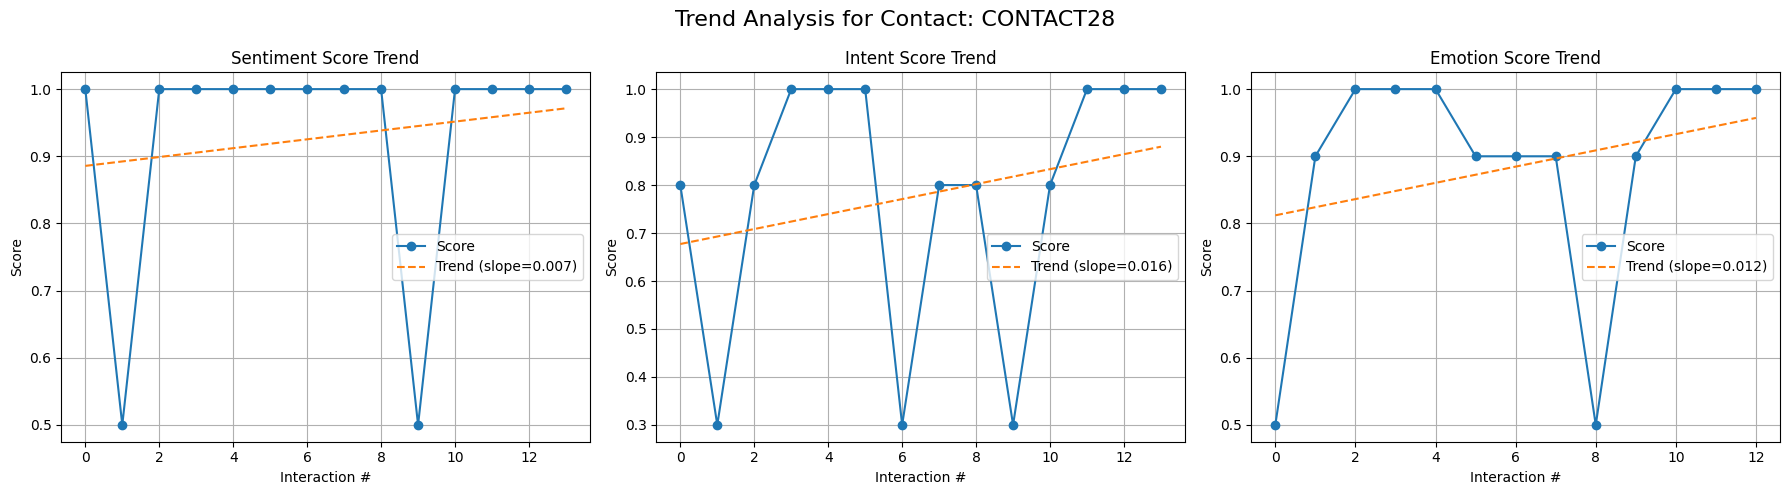

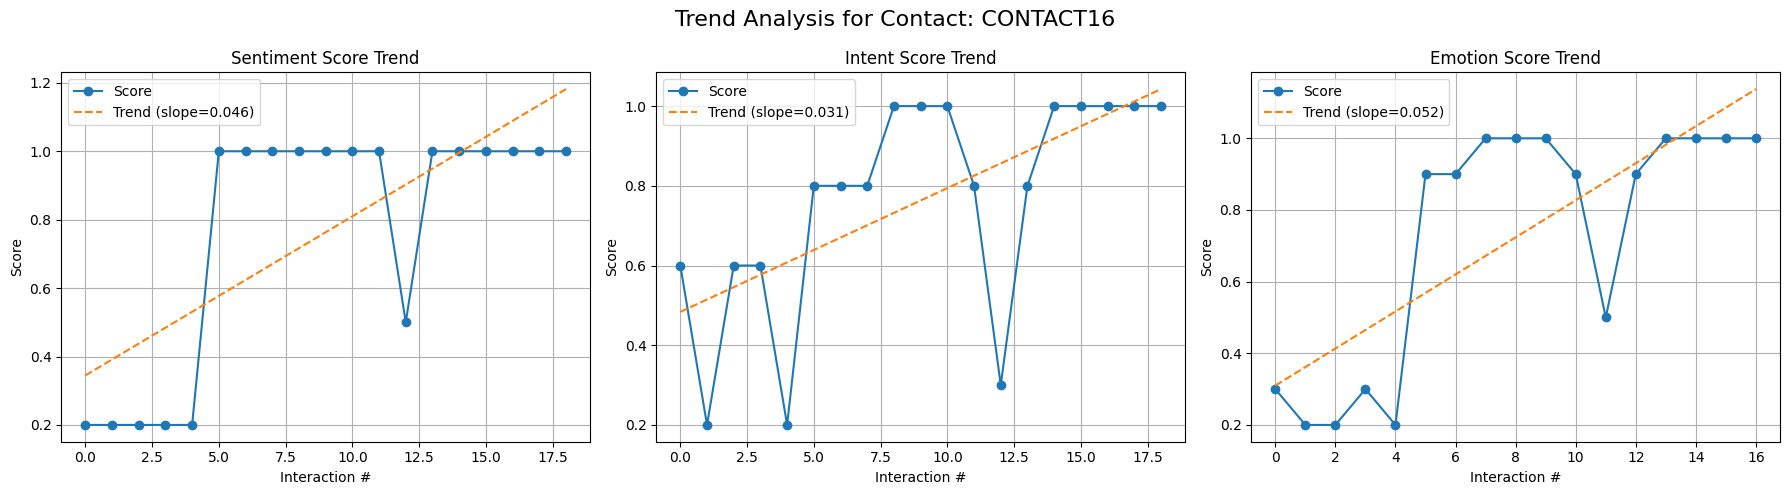

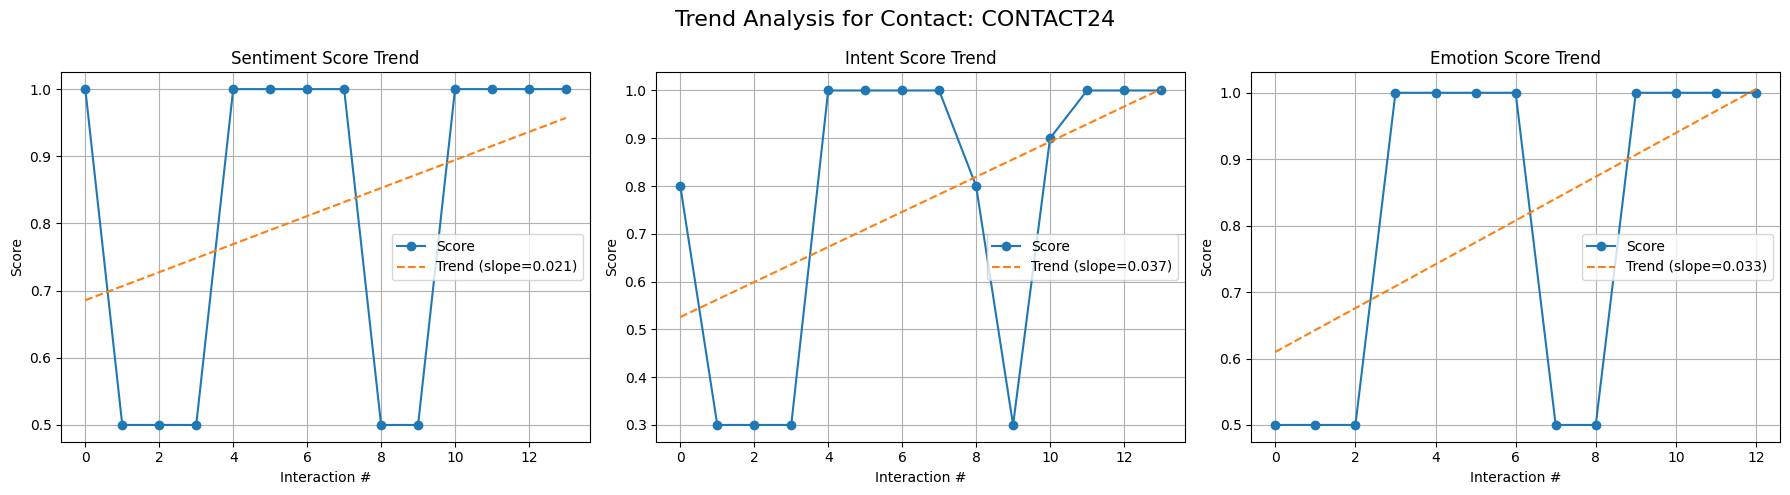

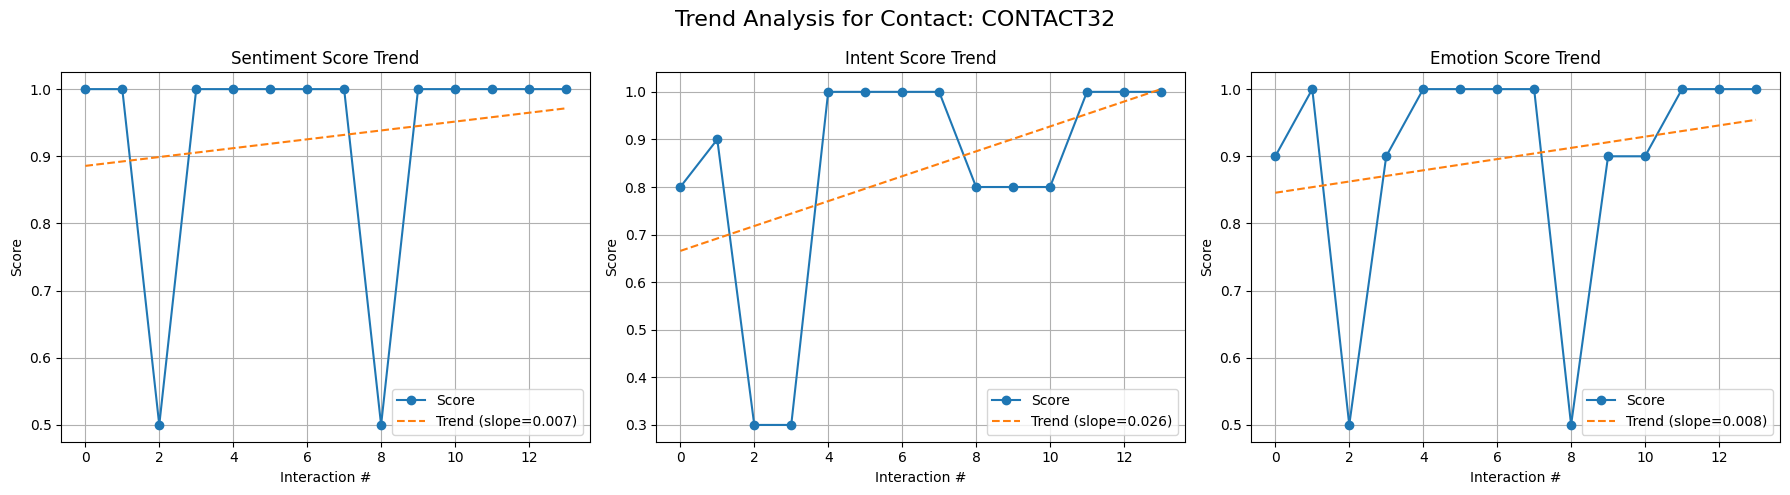

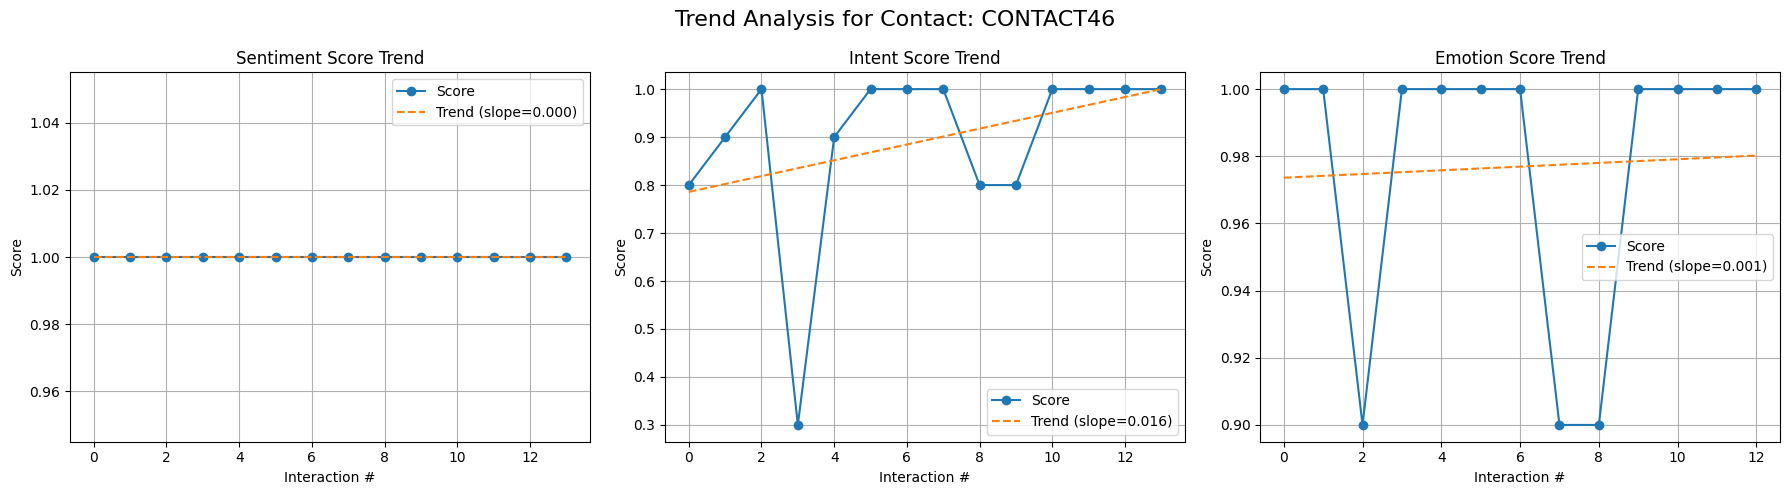

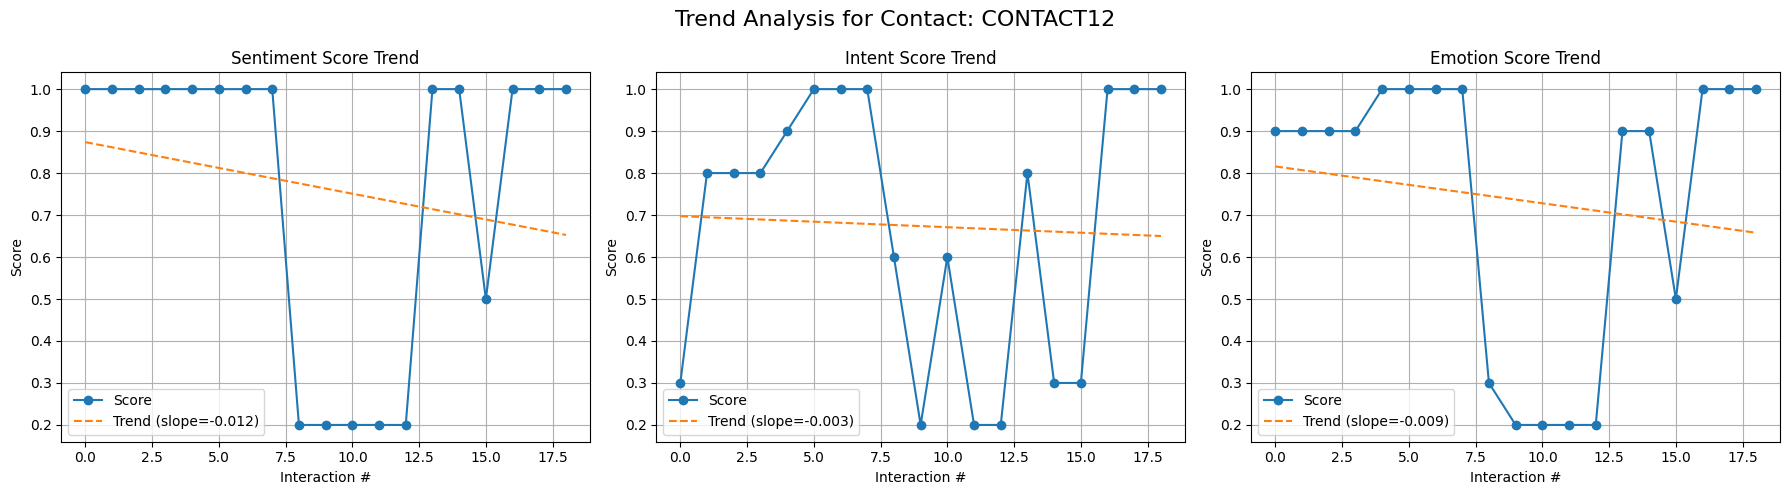

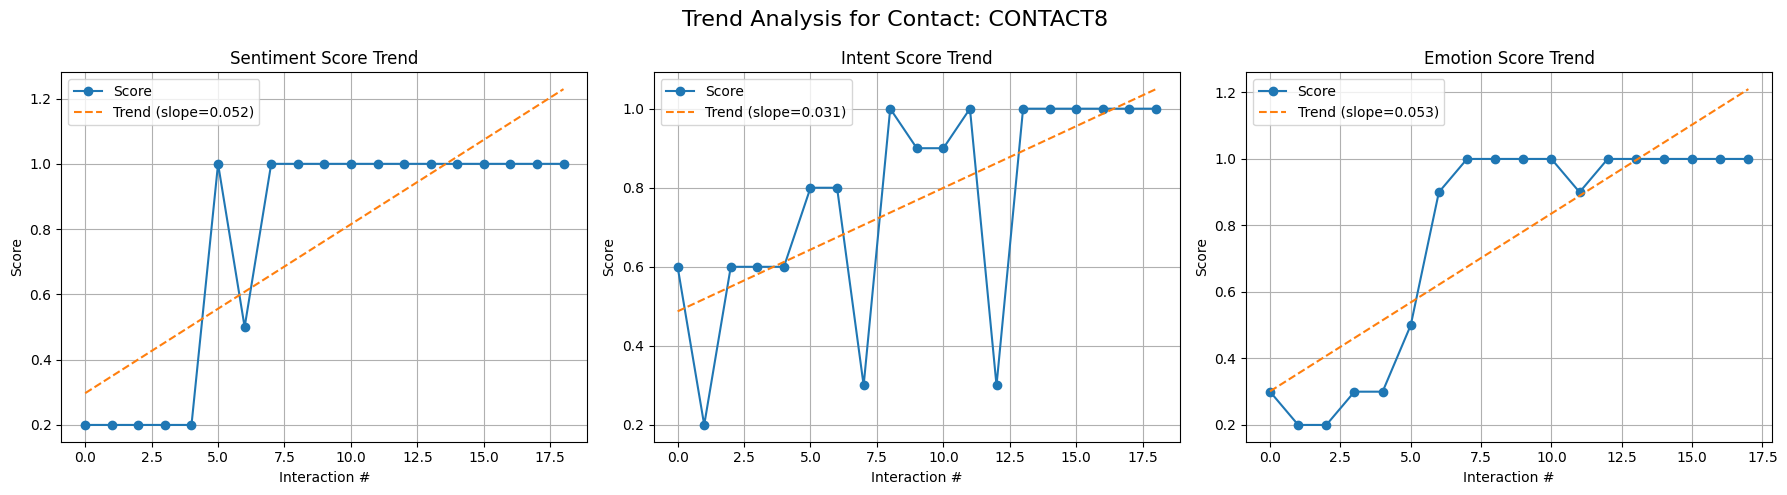

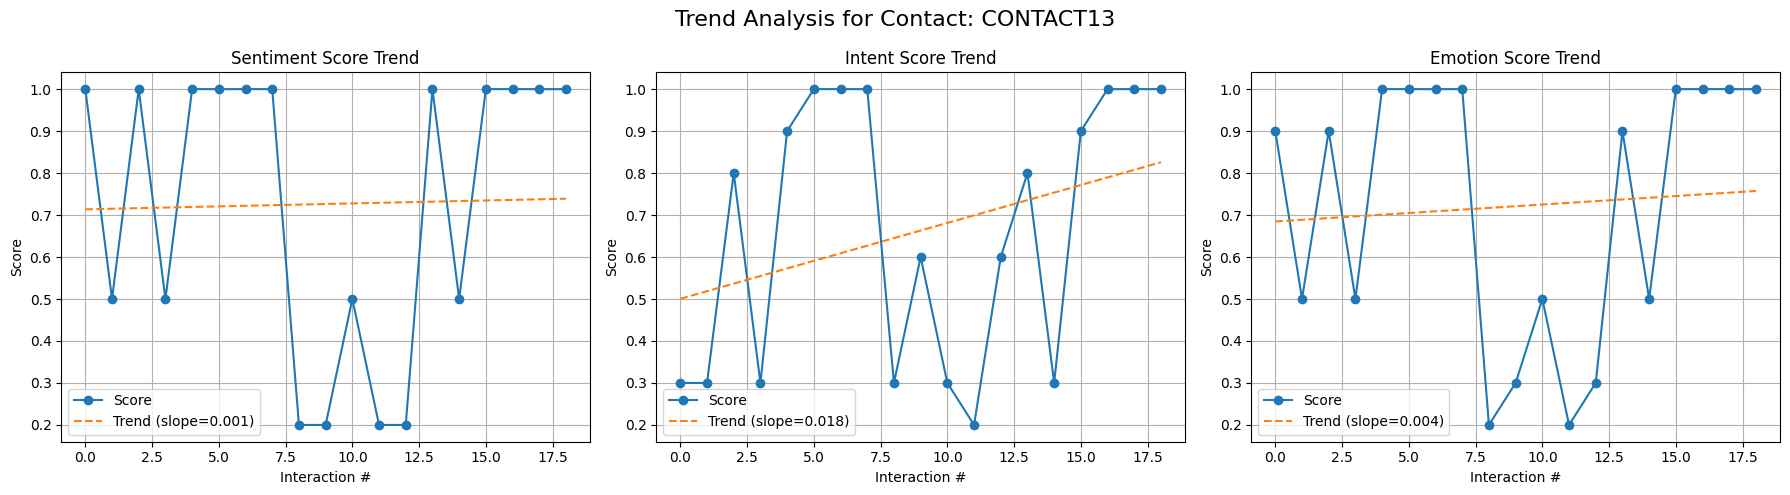

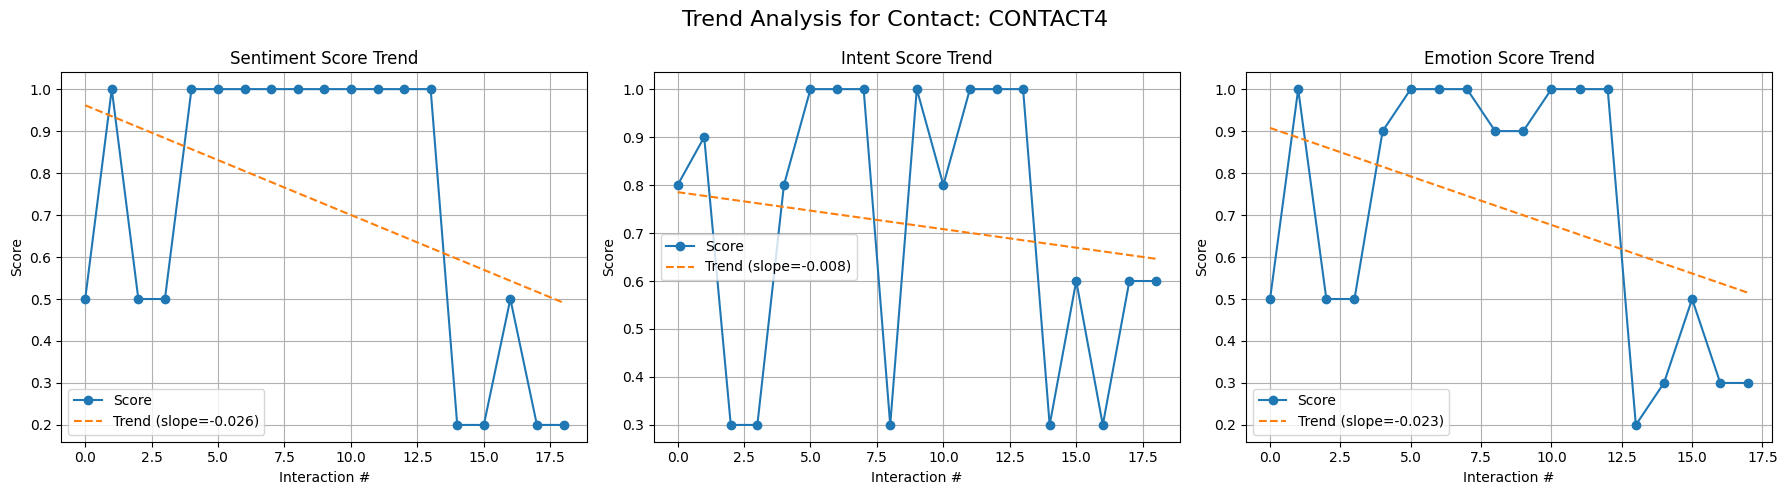

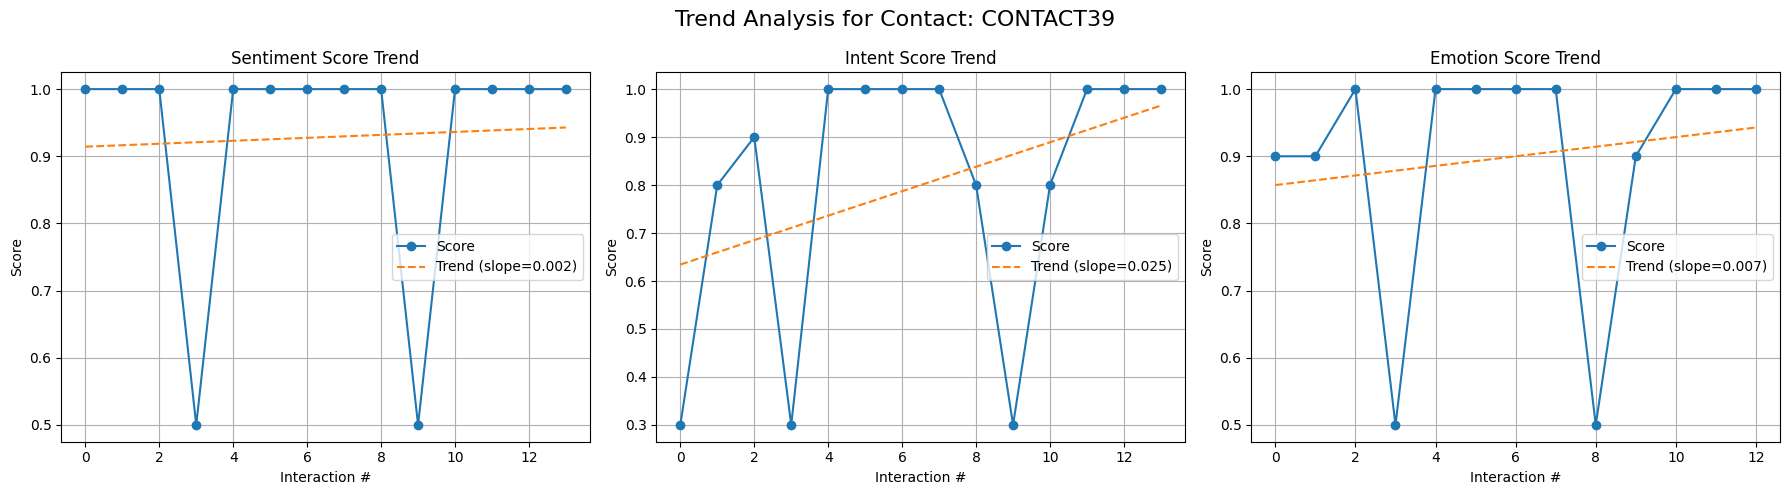

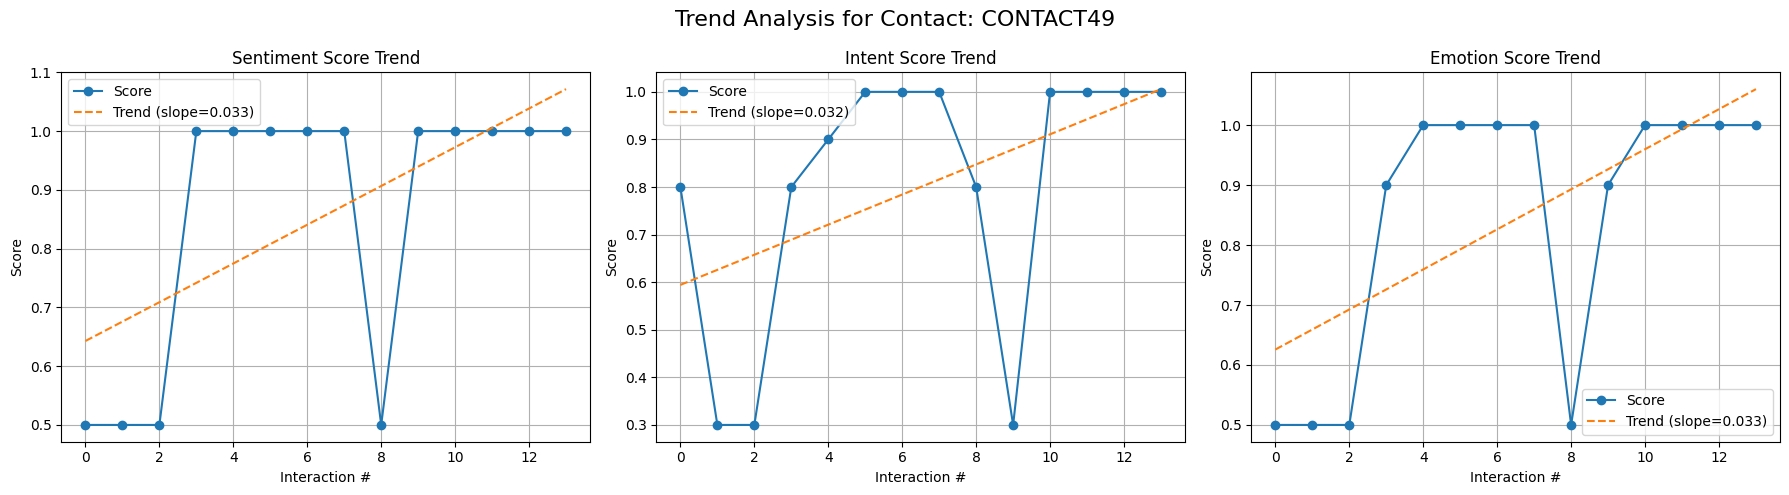

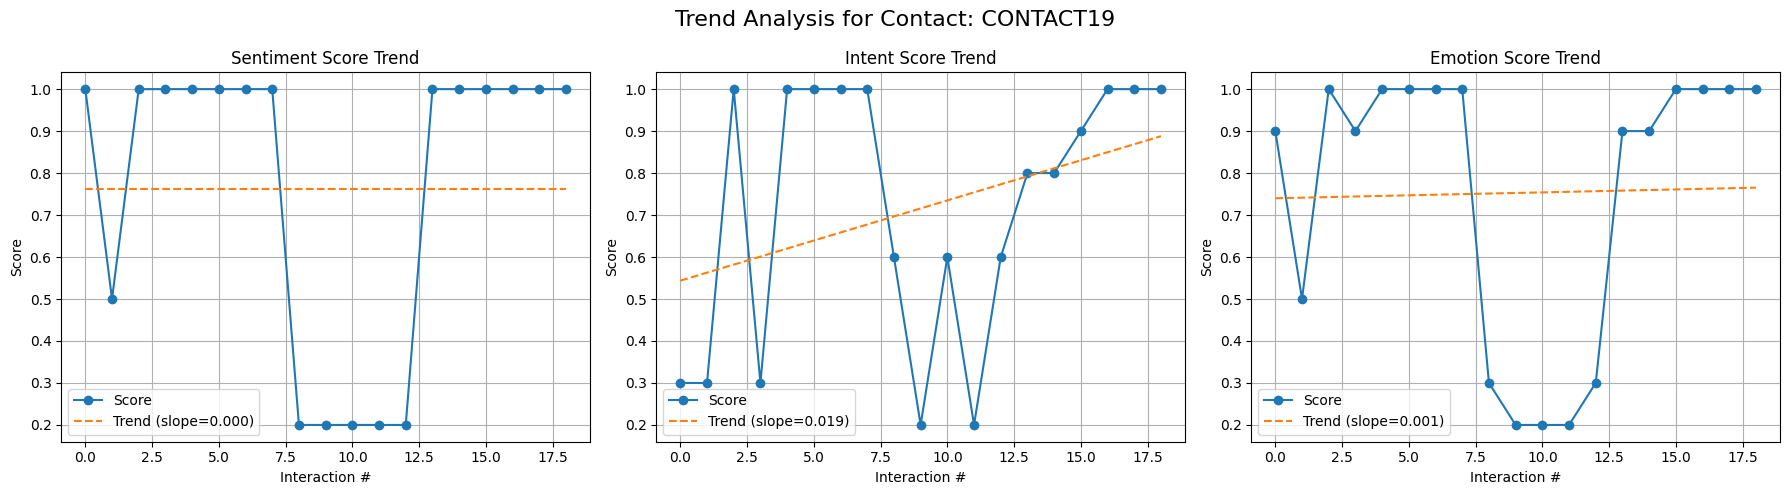

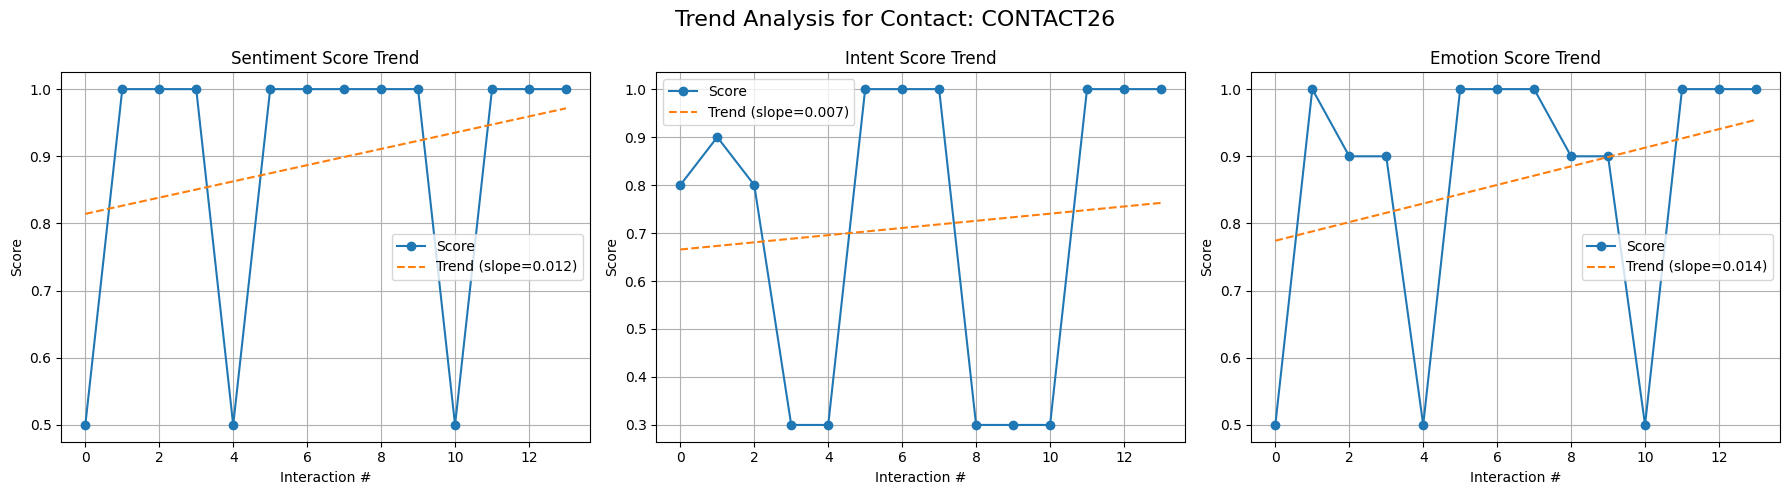

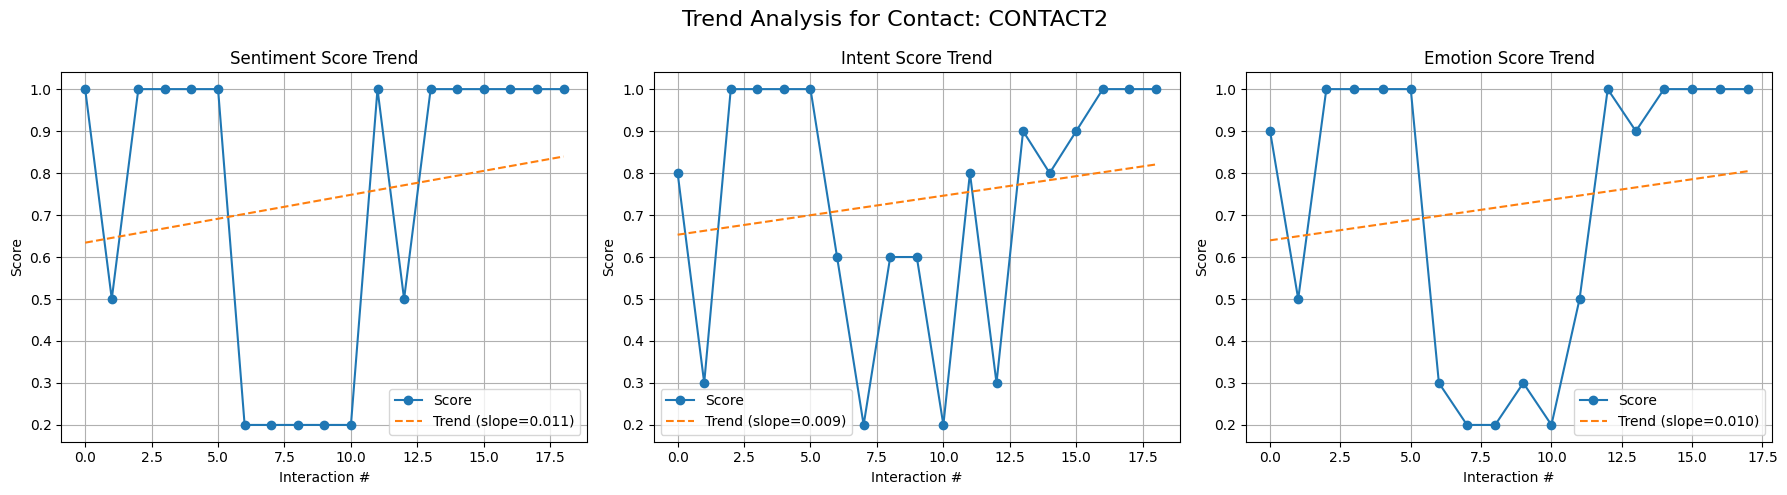

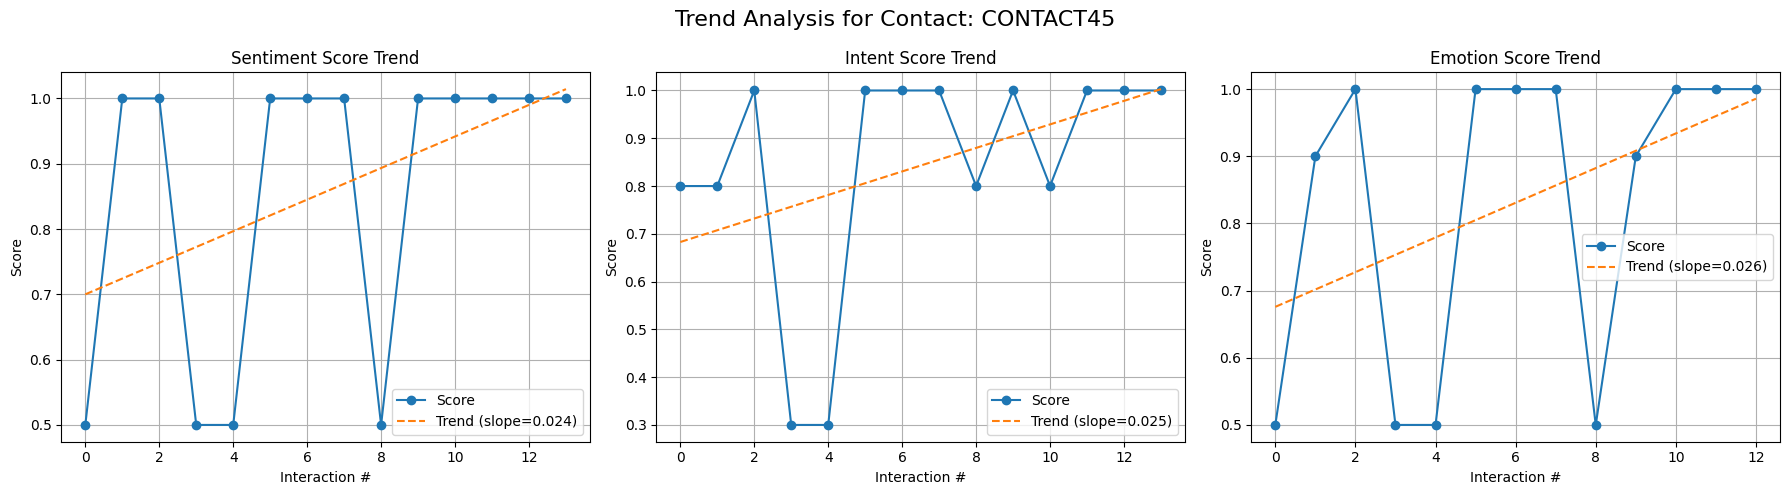

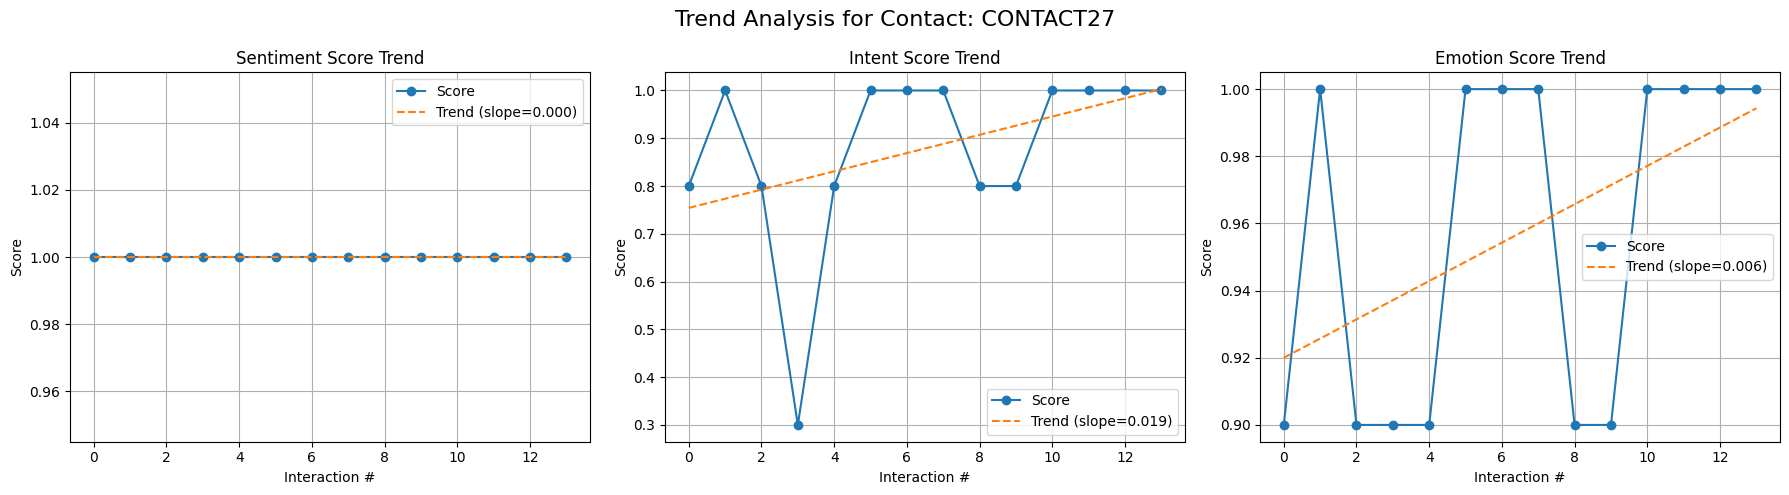

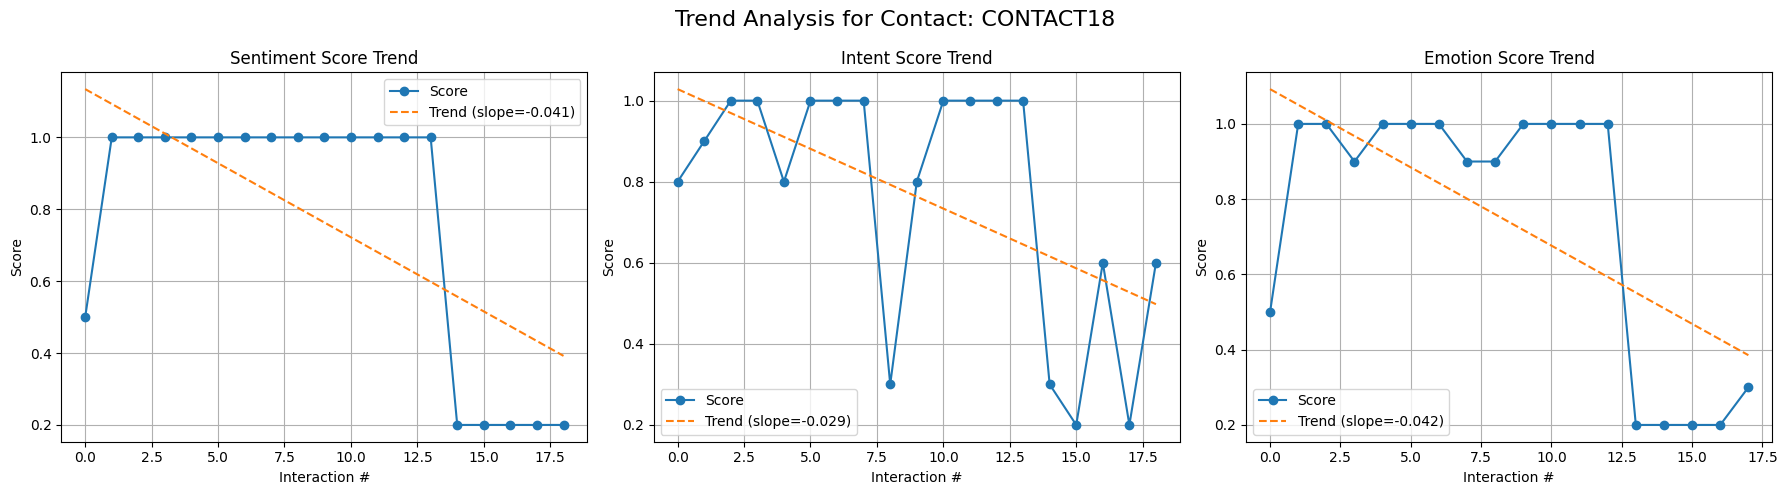

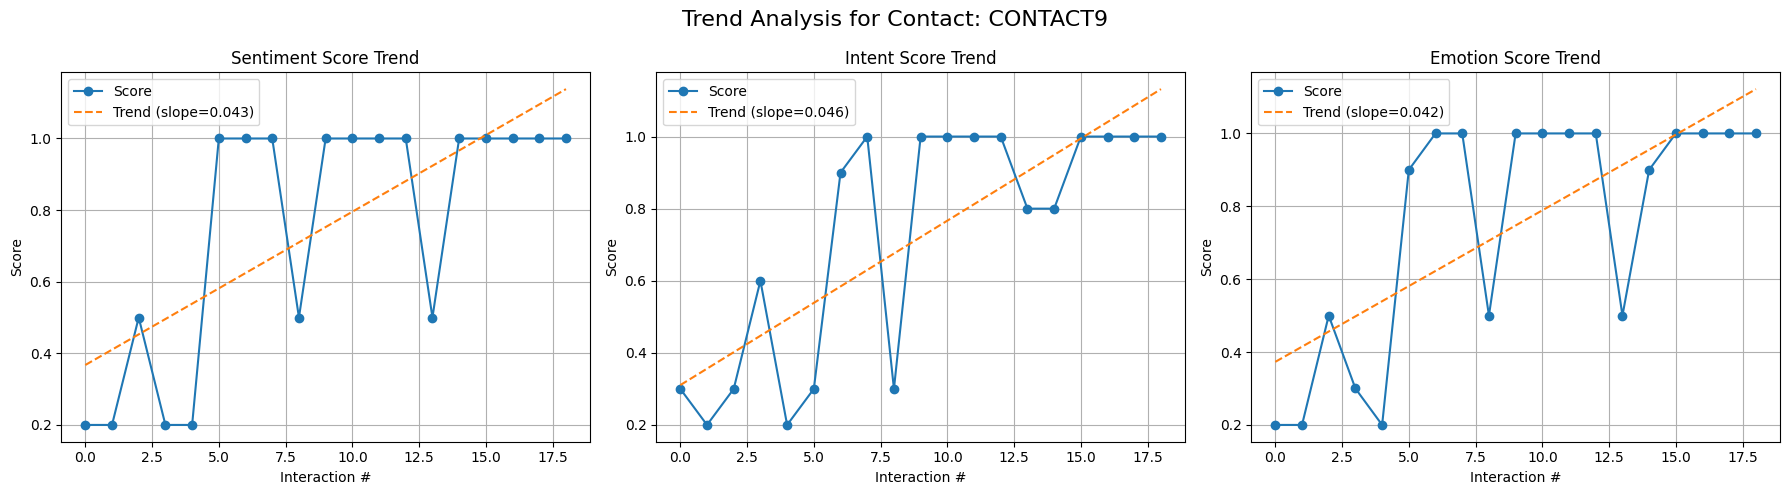

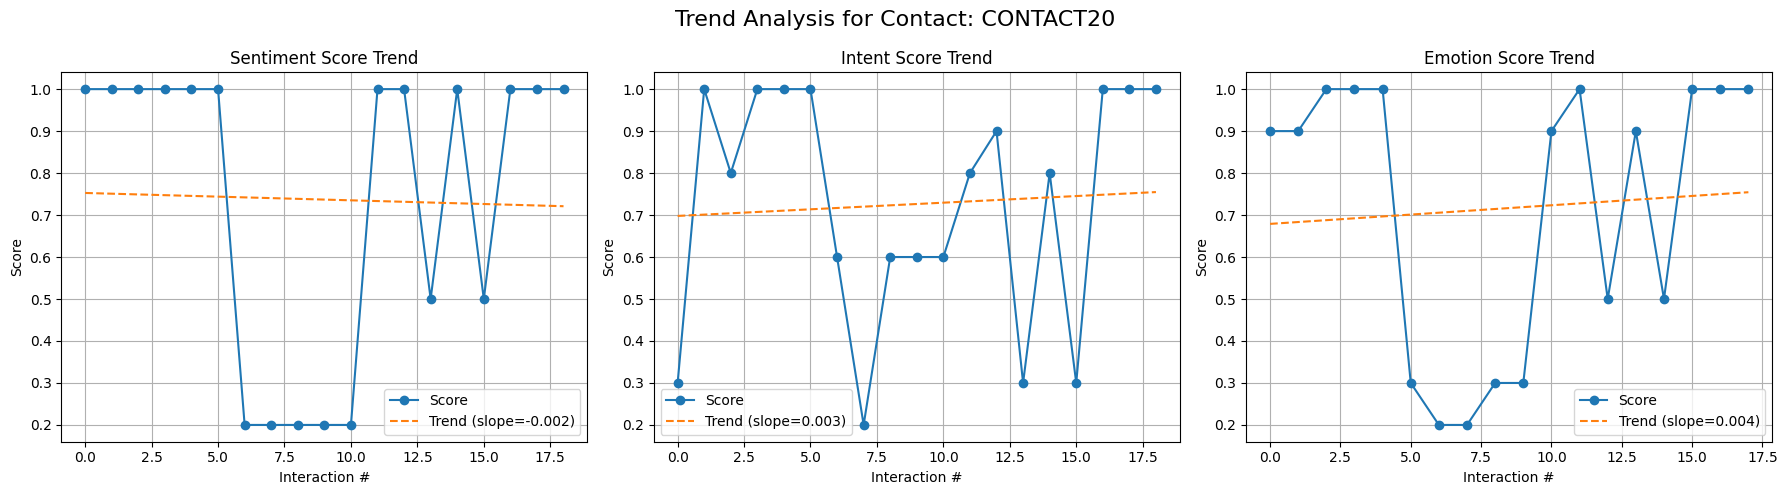

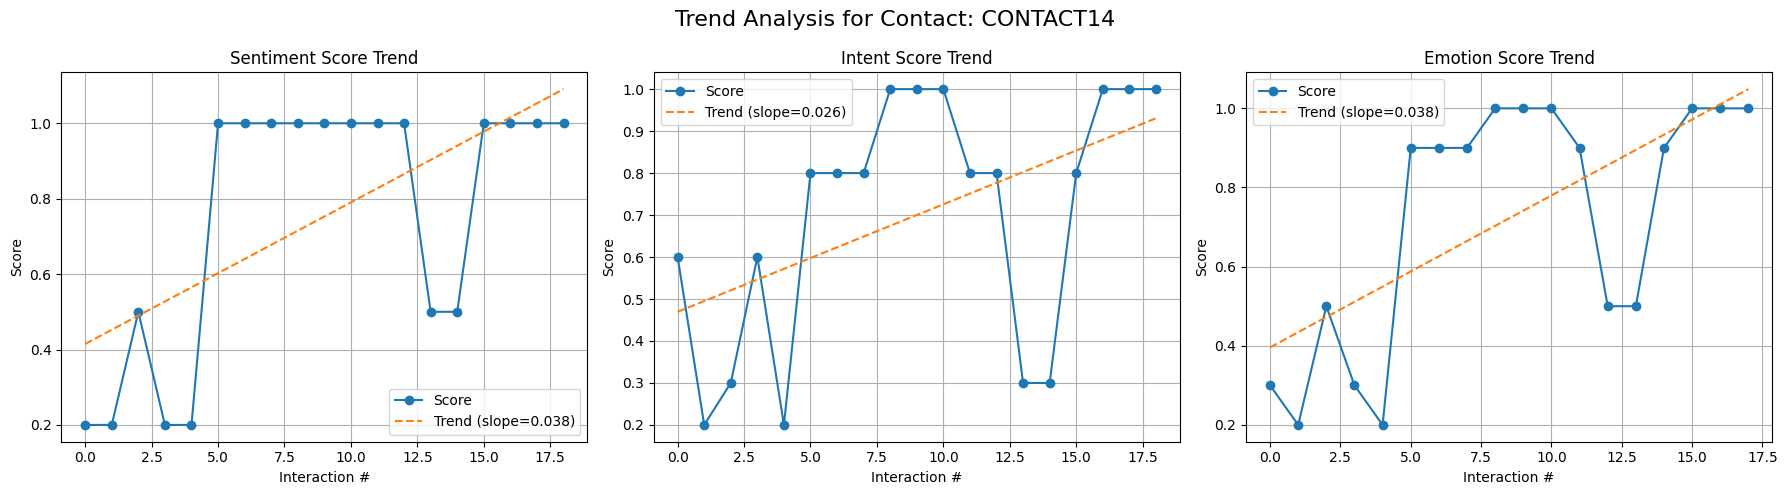

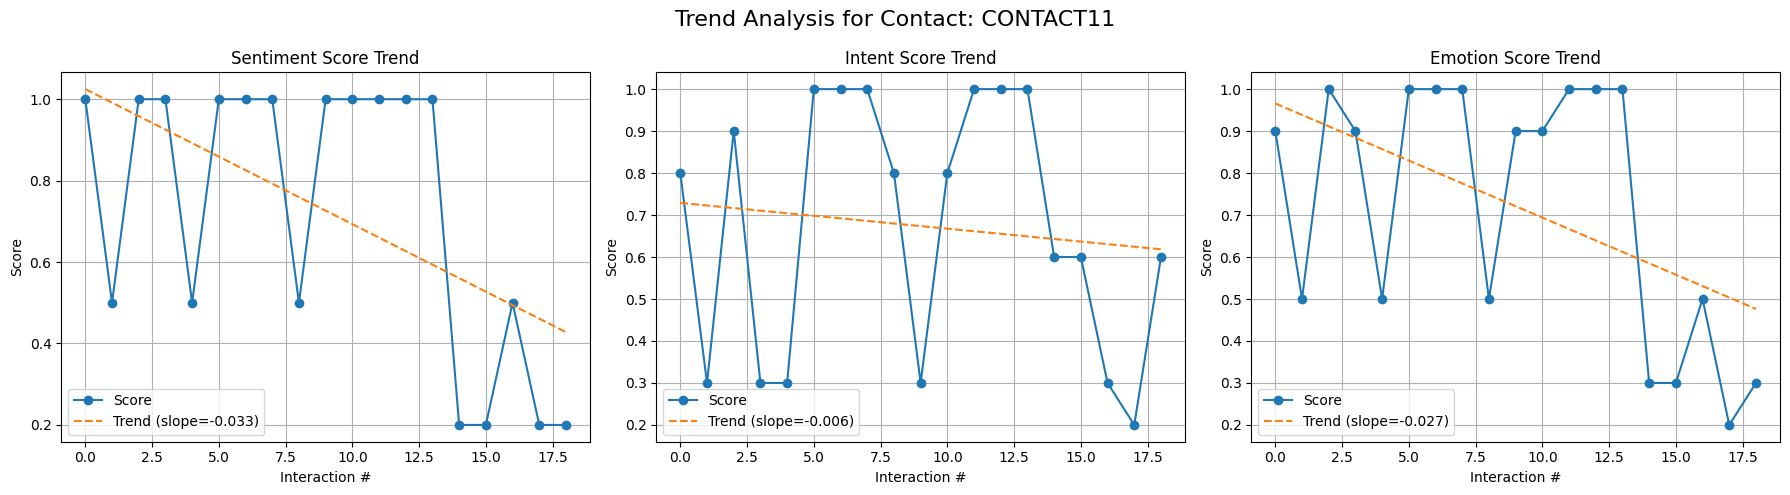

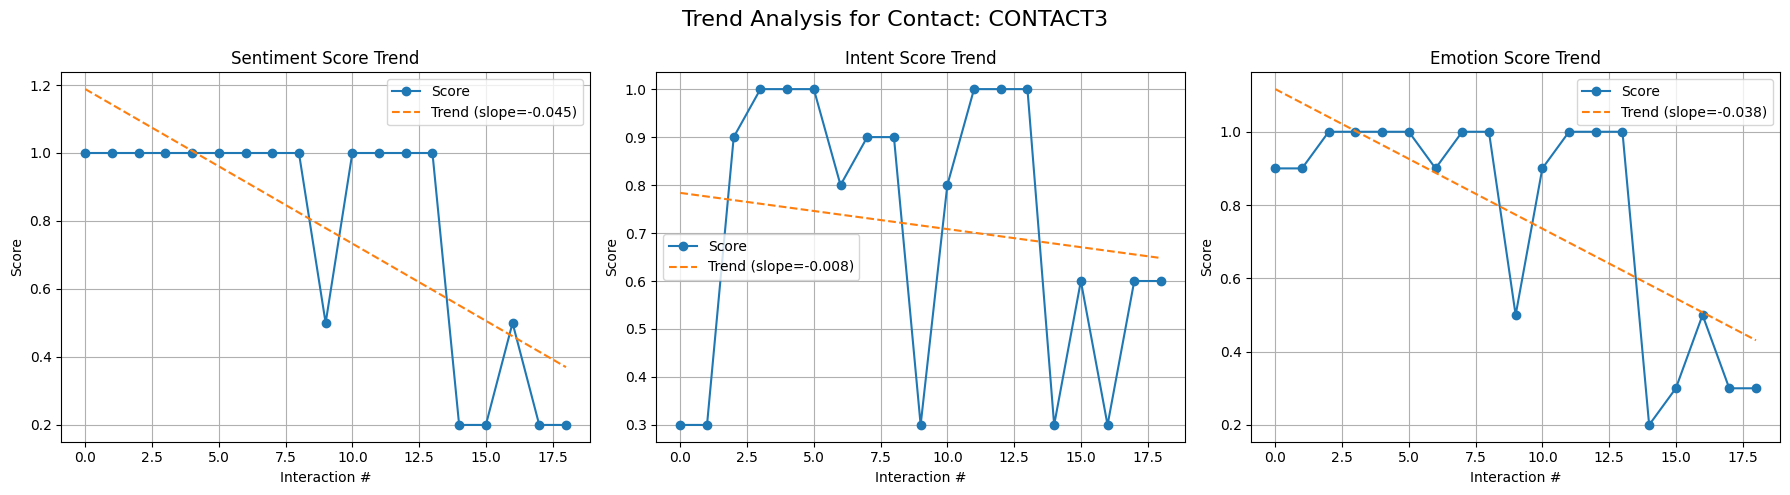

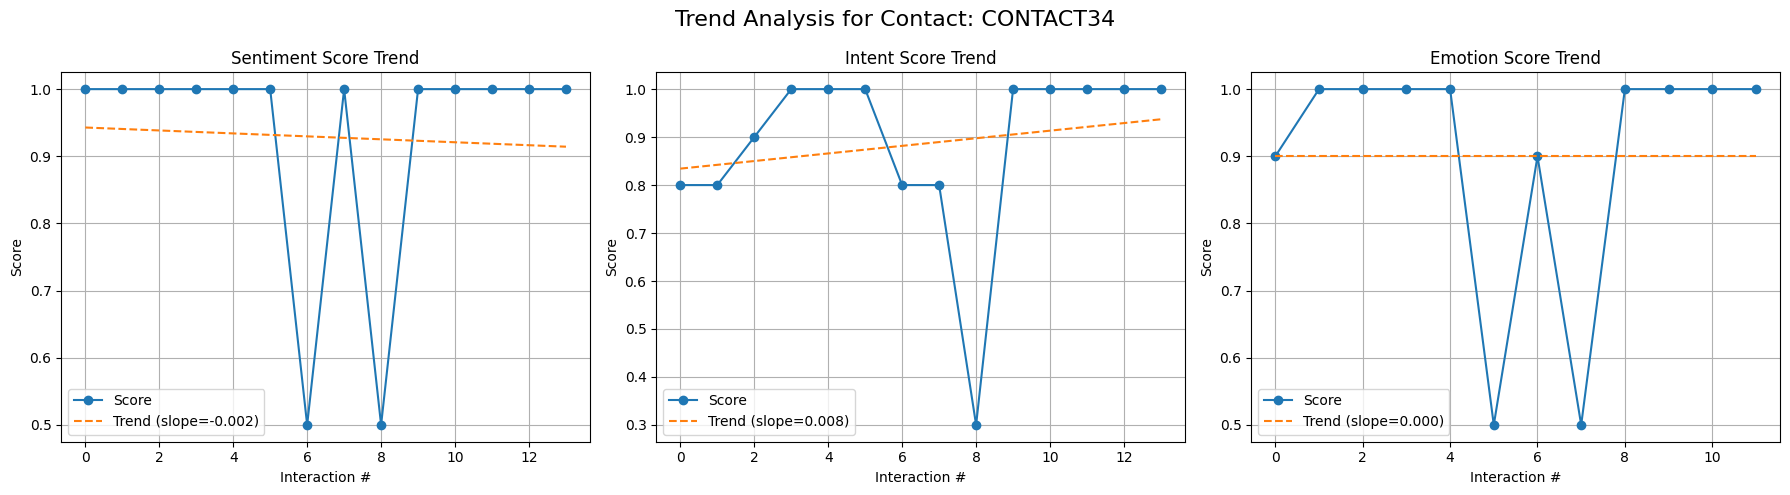

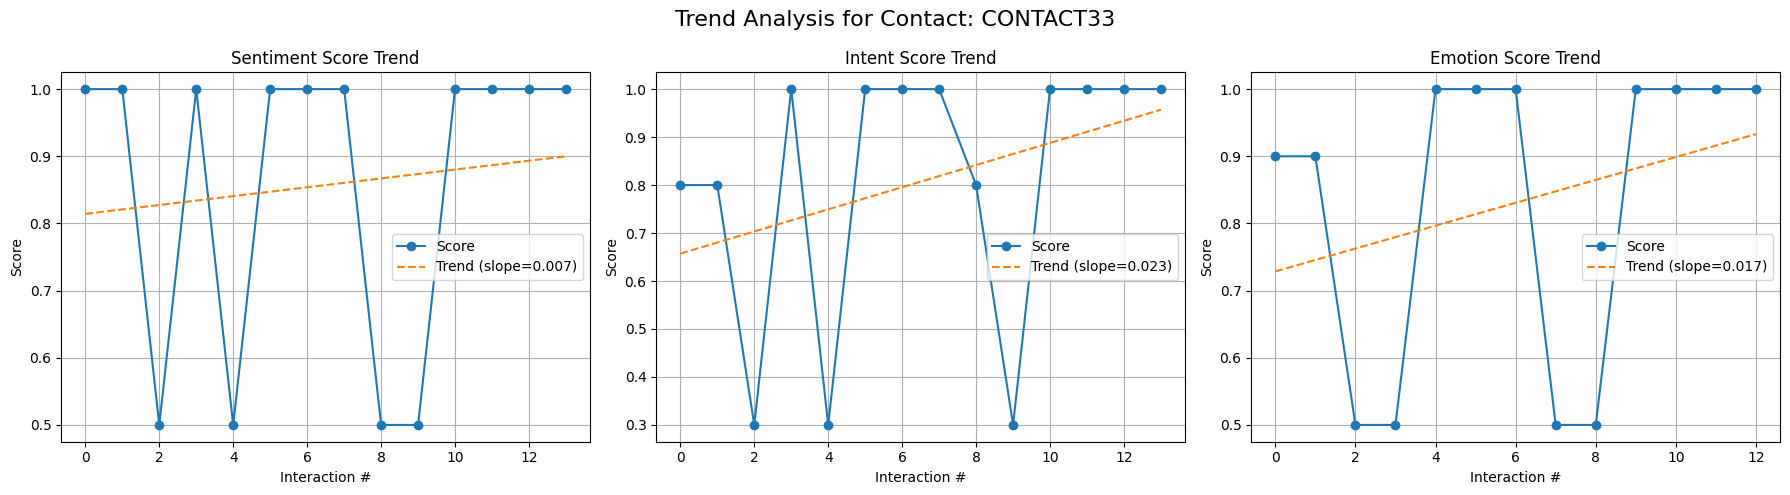

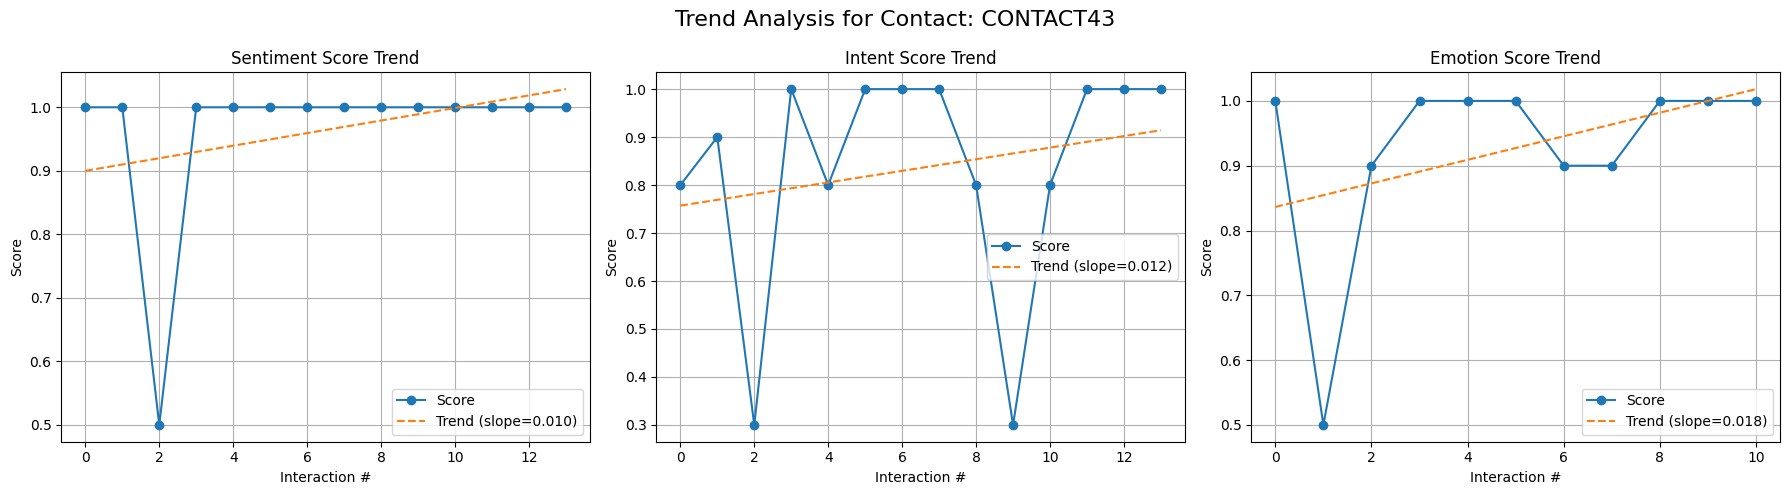

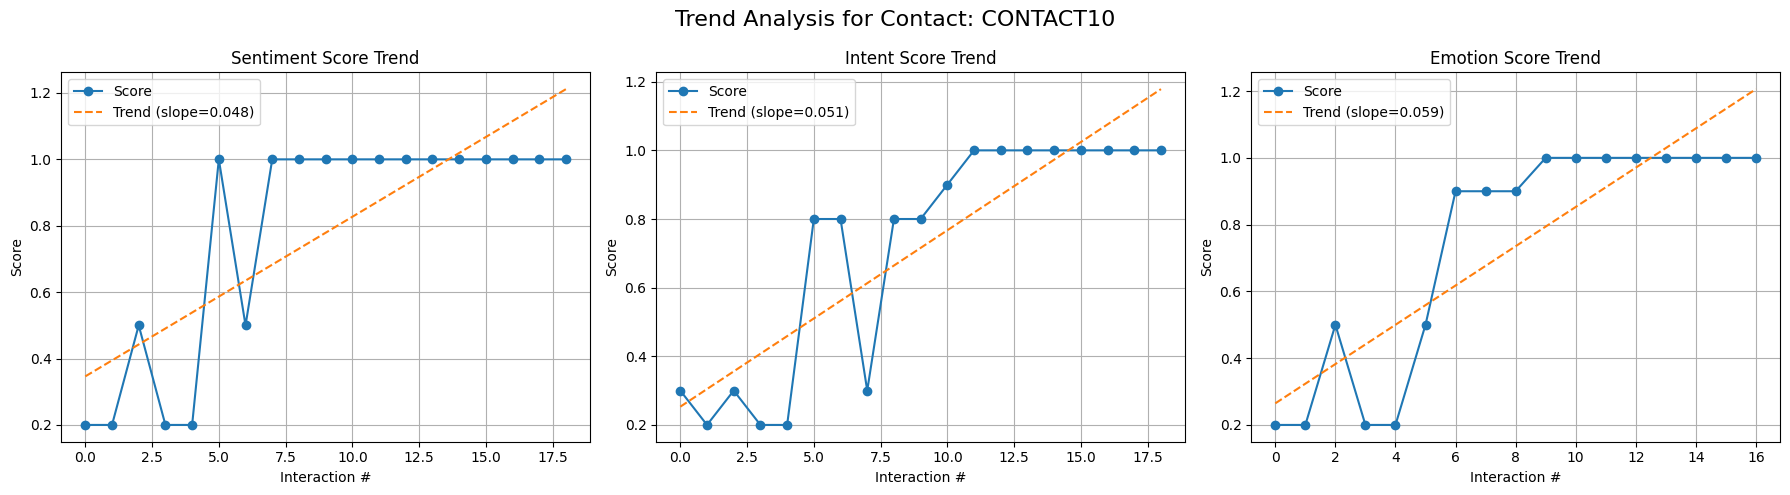

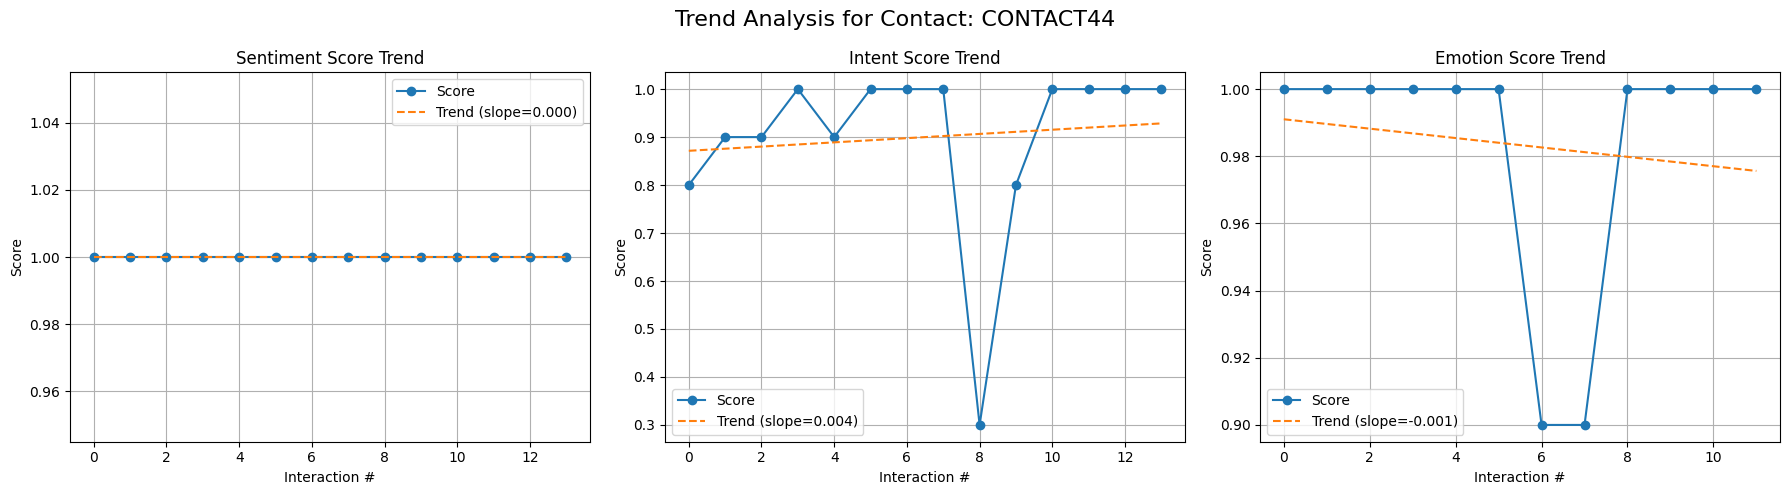

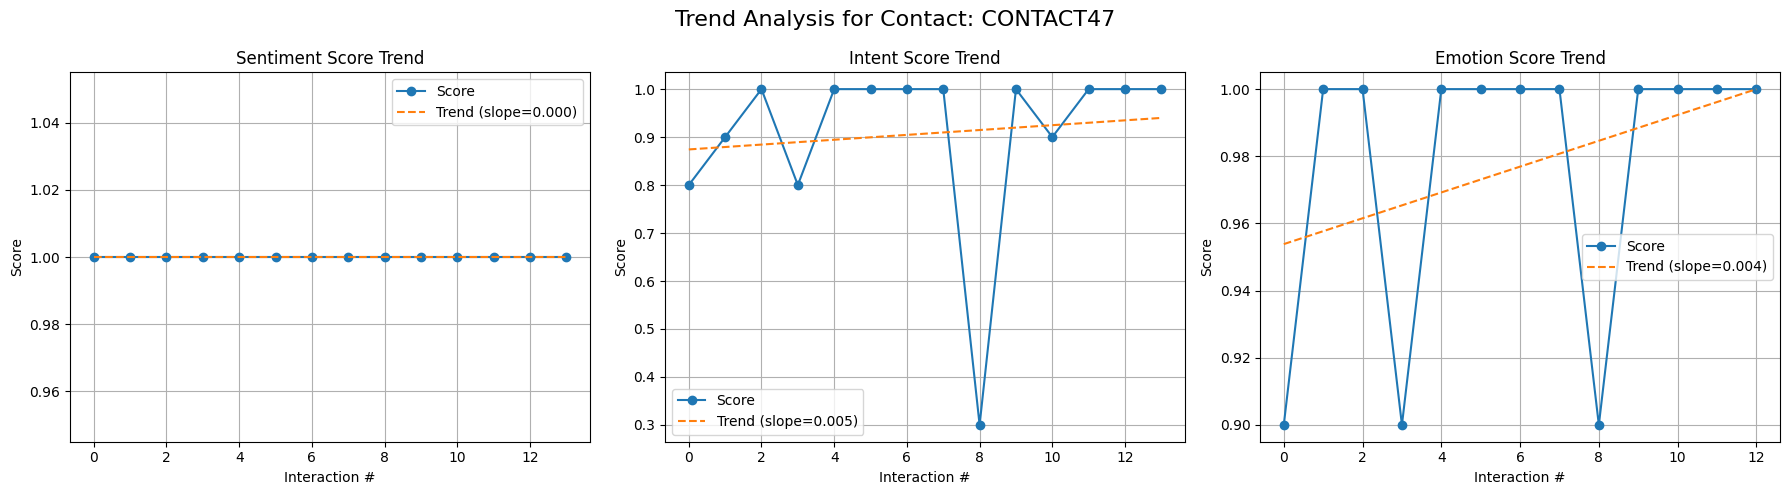

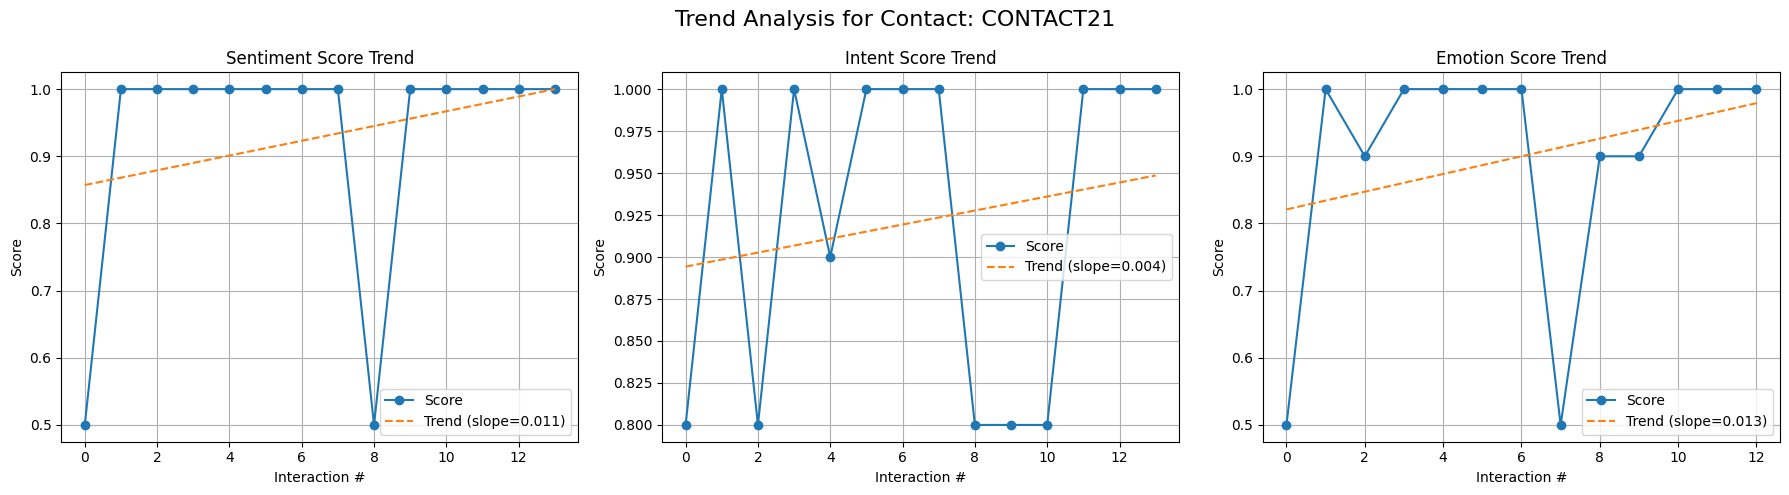

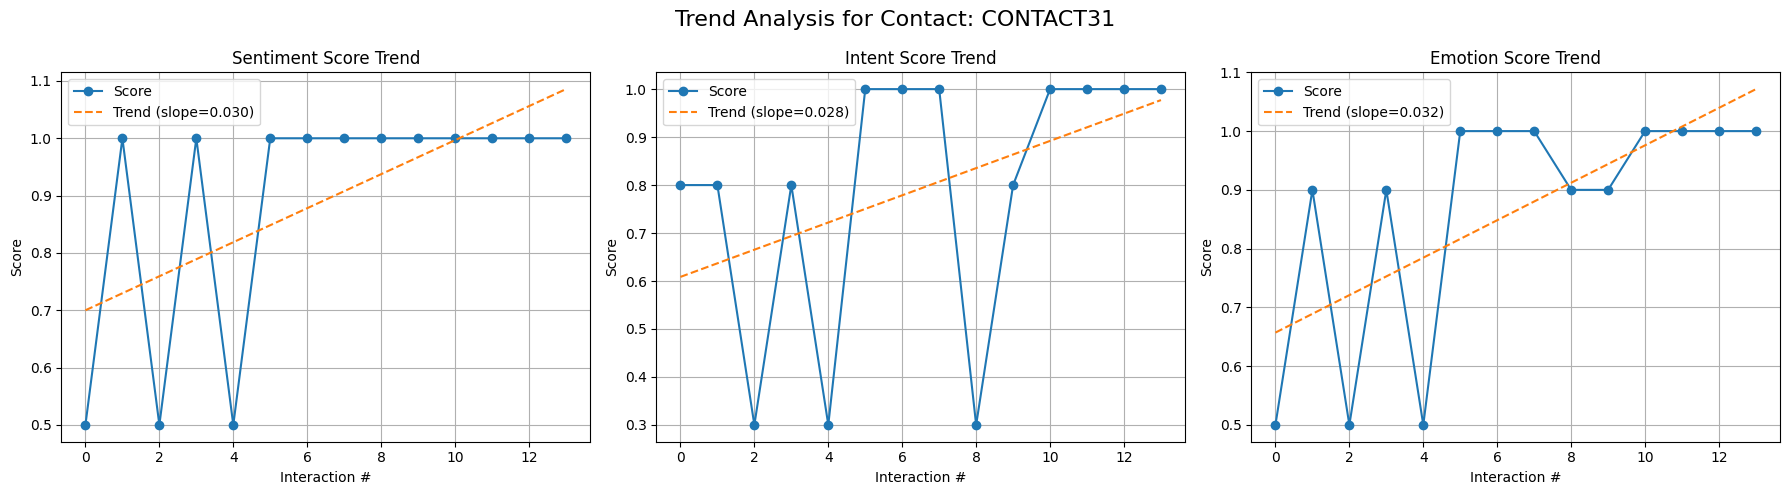

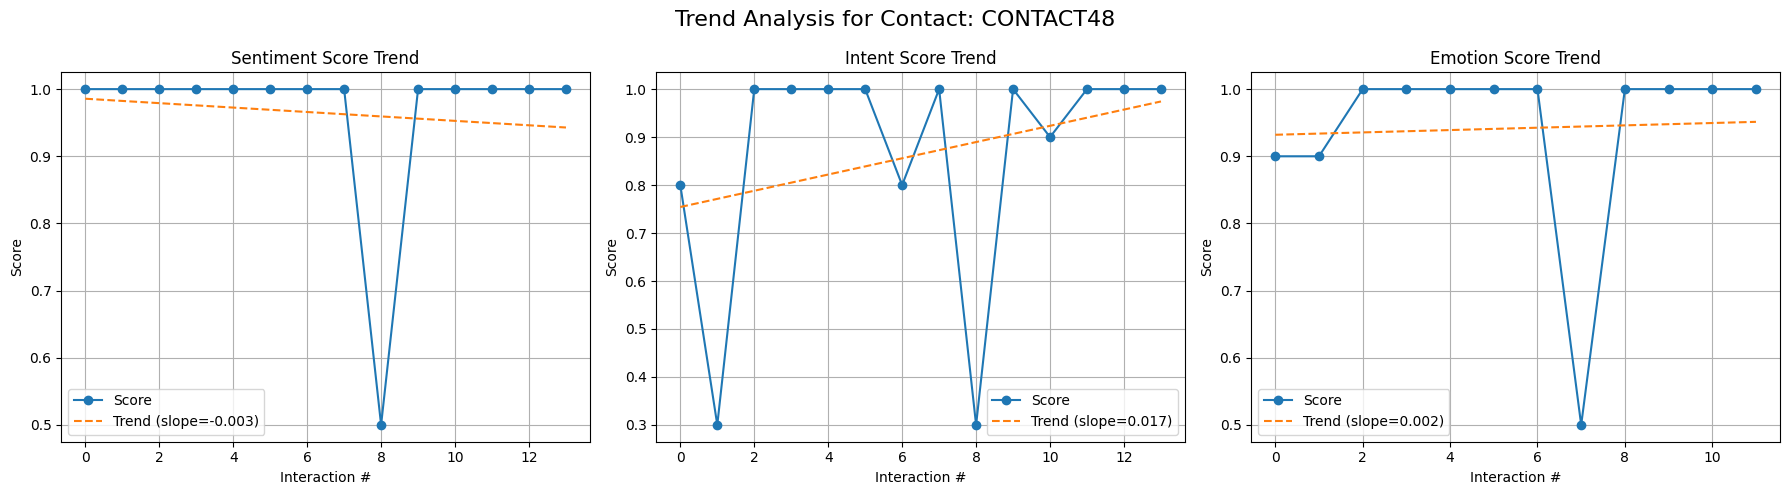

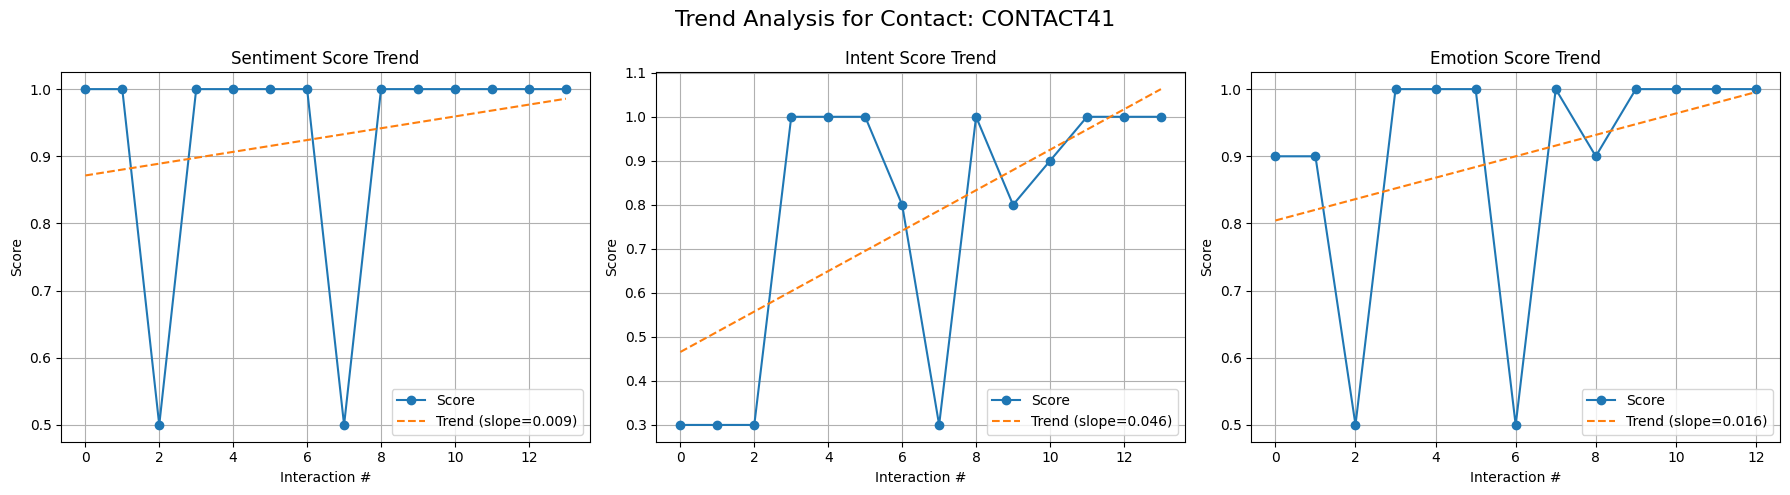

In [98]:
def plot_contact_trends(df, contact_id):
    contact_df = df[df["contact_id"] == contact_id].sort_values("timestamp")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    score_types = ["sentiment_score", "intent_score", "emotion_score"]
    titles = ["Sentiment Score Trend", "Intent Score Trend", "Emotion Score Trend"]

    for i, score_type in enumerate(score_types):
        scores = contact_df[score_type].dropna().tolist()
        if len(scores) < 2:
            axs[i].set_title(f"{titles[i]} (Not enough data)")
            continue

        x = np.arange(len(scores)).reshape(-1, 1)
        y = np.array(scores).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        trend_line = model.predict(x)

        axs[i].plot(x, y, marker='o', label="Score")
        axs[i].plot(x, trend_line, linestyle='--', label=f"Trend (slope={model.coef_[0][0]:.3f})")
        axs[i].set_title(titles[i])
        axs[i].set_xlabel("Interaction #")
        axs[i].set_ylabel("Score")
        axs[i].legend()
        axs[i].grid(True)

    fig.suptitle(f"Trend Analysis for Contact: {contact_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

example_contacts=list(set(df["contact_id"].tolist()))

for contact in example_contacts:
    plot_contact_trends(df, contact)

## Extracting features for contact persona

In [99]:
def compute_trend(values):
    if len(values) < 2:
        return 0
    x = np.arange(len(values)).reshape(-1, 1)
    y = np.array(values).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    return model.coef_[0][0]

contact_features = []
engagement_weights = {"call": 1, "mail": 0.5, "meeting": 1, "invoice": 1, "salesorder": 1, "quote": 1}

for contact_id, group in df.groupby("contact_id"):
    deals = group["deal_id"].nunique()
    amount = group.drop_duplicates("deal_id")["deal_amount"].sum()
    stages = group.drop_duplicates("deal_id")["deal_stage"].nunique()
    deal_win_rate = group[group["class_tag"] == "closed won"].shape[0] / group.shape[0] if group.shape[0] > 0 else 0
    activity_count = group.shape[0]

    # Trend-based scores across all activities in the account
    intent_score = compute_trend(group["intent_score"].dropna().tolist())
    sentiment_score = compute_trend(group["sentiment_score"].dropna().tolist())
    emotion_score = compute_trend(group["emotion_score"].dropna().tolist())

    # Sort timestamps and compute avg gap in days
    timestamps = group.sort_values("timestamp")["timestamp"]

    if len(timestamps) > 1:
        gaps = timestamps.diff().dt.days.dropna()
        activity_frequency = gaps.mean()
    else:
        days_since_last = (pd.Timestamp.now() - timestamps.iloc[0]).days
        activity_frequency = days_since_last

    recency = (pd.Timestamp.now() - group["timestamp"].max()).days
    engagement_score = group["activity_type"].map(engagement_weights).sum()

    contact_features.append({
        "contact_id": contact_id,
        "num_deals": deals,
        "sum_deal_amount": amount,
        "deal_stages": stages,
        "deal_win_rate": deal_win_rate,
        "activity_count": activity_count,
        "recency": recency,
        "activity_frequency": activity_frequency,
        "engagement_score": engagement_score,
        "intent_score": intent_score,
        "sentiment_score": sentiment_score,
        "emotion_score": emotion_score
    })

features_df = pd.DataFrame(contact_features)

## Binning Rules

In [100]:
binning_rules = {}

for column in ["num_deals", "sum_deal_amount", "deal_stages", "deal_win_rate", "activity_count", "recency", "activity_frequency", 'intent_score', 'emotion_score', 'sentiment_score', "engagement_score"]:
    values = features_df[column]
    if (column == "activity_frequency" or column == 'recency'):
        bins = {
            "q3": round(values.quantile(0.75), 2),
            "q2": round(values.quantile(0.50), 2),
            "q1": round(values.quantile(0.25), 2)
        }
    else:
        bins = {
            "q1": round(values.quantile(0.25), 2),
            "q2": round(values.quantile(0.50), 2),
            "q3": round(values.quantile(0.75), 2)
        }
    binning_rules[column] = bins

In [101]:
def bin_score(value, thresholds, reverse=False):
    if reverse:
        if value <= thresholds["q1"]:
            return 1.0
        elif value <= thresholds["q2"]:
            return 0.75
        elif value <= thresholds["q3"]:
            return 0.5
        else:
            return 0.2
    else:
        if value <= thresholds["q1"]:
            return 0.2
        elif value <= thresholds["q2"]:
            return 0.5
        elif value <= thresholds["q3"]:
            return 0.75
        else:
            return 1.0

## Computing final persona score based on weights of each feature scores

In [102]:
def compute_contact_persona_score(contact_features, weights, binning_rules):
    individual_scores = {}
    weighted_scores = []

    for key in binning_rules:
        thresholds = binning_rules[key]
        reverse = (key == "activity_frequency" or key == "recency")
        if key not in ["intent_score", "emotion_score", "sentiment_score"]:
          score = bin_score(contact_features[key], thresholds, reverse)
        else:
          score = contact_features[key]
        individual_scores[key] = score
        weighted_scores.append(score * weights.get(key, 1.0))

    total_weight = sum(weights.values())
    final_score = sum(weighted_scores) / total_weight if total_weight else 0

    return {
        "contact_id": contact_features["contact_id"],
        "final_persona_score": round(final_score, 3),
        "individual_feature_scores": individual_scores
    }

In [103]:
weights = {
    "num_deals": 1.0,
    "sum_deal_amount": 0.5,
    "deal_stages": 1.0,
    "deal_win_rate": 0.5,
    "activity_count": 1,
    "recency": 0.5,
    "activity_frequency": 1.0,
    "engagement_score": 1.0
}

## Storing the result for comparison

In [104]:
scored_personas = [compute_contact_persona_score(row, weights, binning_rules) for row in contact_features]

result_df = [json_data for json_data in scored_personas]

# Flatten it
flat_data = []
for row in result_df:
    base = {
        'contact_id': row['contact_id'],
        'final_persona_score': row['final_persona_score']
    }
    base.update(row['individual_feature_scores'])  # flatten the nested dict
    flat_data.append(base)

# Create DataFrame
result_df = pd.DataFrame(flat_data)

## Comparsion of contact features scores and change in bins

In [105]:
df_before=pd.read_csv('scored_personas_v1.csv')

In [ ]:
def interpret_trend_slope(slope):
    if slope <= -0.01:
        return "Strong Declining"
    elif slope <= -0.003:
        return "Moderately Declining"
    elif slope <= 0.003:
        return "Stable / No Clear Trend"
    elif slope <= 0.01:
        return "Moderately Increasing"
    else:
        return "Strong Increasing"

def get_original_bin_label(score, thresholds):
      if score == 0.2:
          return f"Poorly Engaged (<={thresholds['min']:.2f})"
      elif score == 0.5:
          return f"Moderately Engaged ({thresholds['min']:.2f} - {thresholds['avg']:.2f})"
      else:
          return f"Highly Engaged (>{thresholds['avg']:.2f})"

def get_updated_bin_label(score, thresholds):
      if score == 0.2:
          return f"Very Low Engagement (<={thresholds['q1']:.2f})"
      elif score == 0.5:
          return f"Moderately Low Engagement ({thresholds['q1']:.2f} - {thresholds['q2']:.2f})"
      elif score == 0.75:
          return f"Moderately High Engagement ({thresholds['q2']:.2f} - {thresholds['q3']:.2f})"
      else:
          return f"Very High Engagement (>{thresholds['q3']:.2f})"

original_binning_rules = {
    'num_deals': {'min': 1, 'avg': np.float64(2.67), 'max': 5},
    'sum_deal_amount': {'min': 5000, 'avg': np.float64(26936.33), 'max': 48876},
    'deal_stages': {'min': 1, 'avg': np.float64(2.08), 'max': 3},
    'activity_count': {'min': 1, 'avg': np.float64(15.0), 'max': 36},
    'activity_frequency': {'max': 30.0, 'avg': np.float64(7.44), 'min': 1.09},
    'engagement_score': {'min': 0.5, 'avg': np.float64(12.42), 'max': 29.5}
}

In [107]:
def compare_contact_metrics(contact_id_to_compare, df_before, result_df):
    contact_before = df_before[df_before['contact_id'] == contact_id_to_compare].iloc[0]
    contact_after = result_df[result_df['contact_id'] == contact_id_to_compare].iloc[0]

    features_to_bin = [
        'num_deals', 'sum_deal_amount', 'deal_stages', 'deal_win_rate', 'recency',
        'activity_count', 'activity_frequency', 'engagement_score',
        'intent_score', 'emotion_score', 'sentiment_score'
    ]

    rows = []

    for feat in features_to_bin:
        row = {
            "Feature": feat,
            "Original Threshold": None,
            "Original Score": None,
            "Original Bin": None,
            "Updated Threshold": None,
            "Updated Score": None,
            "Updated Bin": None,
            "Trend": None
        }

        # Original binning
        if feat in contact_before and feat in original_binning_rules:
            score_before = contact_before[feat]
            thresholds_original = original_binning_rules[feat]
            bin_label_original = get_original_bin_label(score_before, thresholds_original)
            row["Original Threshold"] = str(thresholds_original)
            row["Original Score"] = round(float(score_before), 2)
            row["Original Bin"] = bin_label_original

        # Updated binning or trend
        if feat in ["intent_score", "emotion_score", "sentiment_score"]:
            score_after = contact_after[feat]
            trend_label = interpret_trend_slope(score_after)
            row["Updated Score"] = round(float(score_after), 4)  # Keep more precision here
            row["Trend"] = trend_label
        elif feat in contact_after and feat in binning_rules:
            score_after = contact_after[feat]
            thresholds_updated = binning_rules[feat]
            bin_label_updated = get_updated_bin_label(score_after, thresholds_updated)
            row["Updated Threshold"] = str(thresholds_updated)
            row["Updated Score"] = round(float(score_after), 2)
            row["Updated Bin"] = bin_label_updated

        rows.append(row)

    return pd.DataFrame(rows)

df_metrics = compare_contact_metrics('CONTACT11', df_before, result_df)
display(df_metrics)


Feature                                 Original Threshold  \
0            num_deals      {'min': 1, 'avg': np.float64(2.67), 'max': 5}   
1      sum_deal_amount  {'min': 5000, 'avg': np.float64(26936.33), 'ma...   
2          deal_stages      {'min': 1, 'avg': np.float64(2.08), 'max': 3}   
3        deal_win_rate                                               None   
4              recency                                               None   
5       activity_count     {'min': 1, 'avg': np.float64(15.0), 'max': 36}   
6   activity_frequency  {'max': 30.0, 'avg': np.float64(7.44), 'min': ...   
7     engagement_score  {'min': 0.5, 'avg': np.float64(12.42), 'max': ...   
8         intent_score                                               None   
9        emotion_score                                               None   
10     sentiment_score                                               None   

    Original Score                Original Bin  \
0              1.0      Highly Engaged (>2.67)   
1              0.2  Poorly Engaged (<=5000.00)   
2              0.2     Poorly Engaged (<=1.00)   
3              NaN                        None   
4              NaN                        None   
5              1.0     Highly Engaged (>15.00)   
6              0.2     Poorly Engaged (<=1.09)   
7              1.0     Highly Engaged (>12.42)   
8              NaN                        None   
9              NaN                        None   
10             NaN                        None   

                                    Updated Threshold  Updated Score  \
0   {'q1': np.float64(2.0), 'q2': np.float64(2.0),...         0.7500   
1   {'q1': np.float64(0.0), 'q2': np.float64(0.0),...         0.2000   
2   {'q1': np.float64(1.0), 'q2': np.float64(1.0),...         0.2000   
3   {'q1': np.float64(0.74), 'q2': np.float64(1.0)...         0.2000   
4   {'q3': np.float64(50.0), 'q2': np.float64(48.0...         1.0000   
5   {'q1': np.float64(14.0), 'q2': np.float64(14.0...         0.7500   
6   {'q3': np.float64(1.11), 'q2': np.float64(0.91...         0.2000   
7   {'q1': np.float64(13.0), 'q2': np.float64(13.0...         0.7500   
8                                                None         0.0295   
9                                                None         0.0396   
10                                               None         0.0446   

                                   Updated Bin              Trend  
0     Moderately High Engagement (2.00 - 3.00)               None  
1                 Very Low Engagement (<=0.00)               None  
2                 Very Low Engagement (<=1.00)               None  
3                 Very Low Engagement (<=0.74)               None  
4                Very High Engagement (>50.00)               None  
5   Moderately High Engagement (14.00 - 19.00)               None  
6                 Very Low Engagement (<=0.44)               None  
7   Moderately High Engagement (13.00 - 17.50)               None  
8                                         None  Strong Increasing  
9                                         None  Strong Increasing  
10                                        None  Strong Increasing

## Comparision of change in bins of all features between current version and updated version as charts

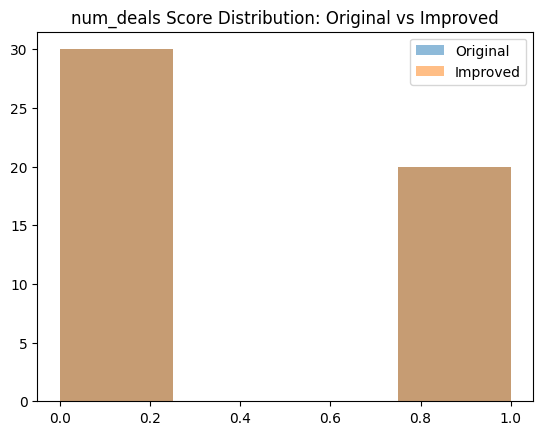

       num_deals_before  num_deals_after
count         50.000000        50.000000
mean           0.520000         0.420000
std            0.395897         0.272179
min            0.200000         0.200000
25%            0.200000         0.200000
50%            0.200000         0.200000
75%            1.000000         0.750000
max            1.000000         0.750000


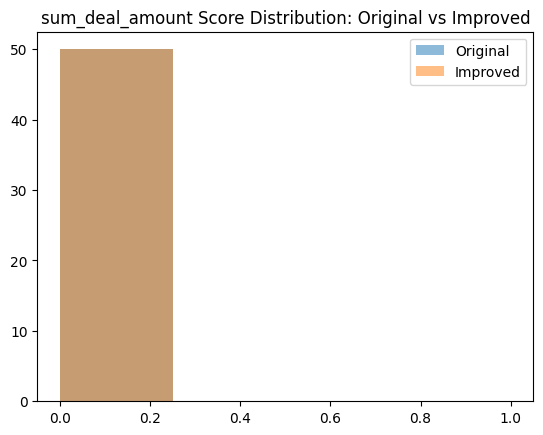

       sum_deal_amount_before  sum_deal_amount_after
count            5.000000e+01           5.000000e+01
mean             2.000000e-01           2.000000e-01
std              8.411210e-17           8.411210e-17
min              2.000000e-01           2.000000e-01
25%              2.000000e-01           2.000000e-01
50%              2.000000e-01           2.000000e-01
75%              2.000000e-01           2.000000e-01
max              2.000000e-01           2.000000e-01


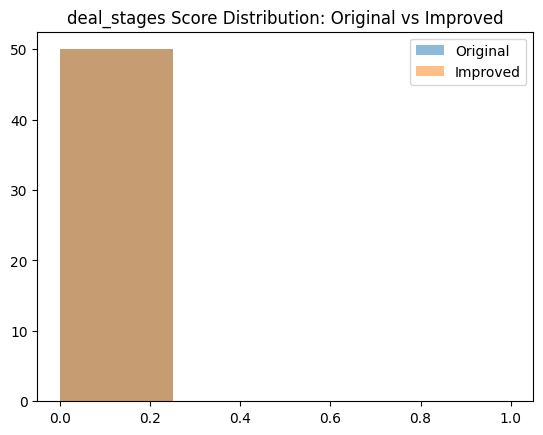

       deal_stages_before  deal_stages_after
count        5.000000e+01       5.000000e+01
mean         2.000000e-01       2.000000e-01
std          8.411210e-17       8.411210e-17
min          2.000000e-01       2.000000e-01
25%          2.000000e-01       2.000000e-01
50%          2.000000e-01       2.000000e-01
75%          2.000000e-01       2.000000e-01
max          2.000000e-01       2.000000e-01


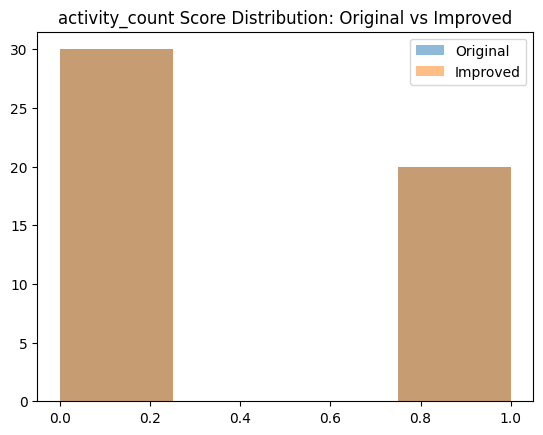

       activity_count_before  activity_count_after
count              50.000000             50.000000
mean                0.520000              0.420000
std                 0.395897              0.272179
min                 0.200000              0.200000
25%                 0.200000              0.200000
50%                 0.200000              0.200000
75%                 1.000000              0.750000
max                 1.000000              0.750000


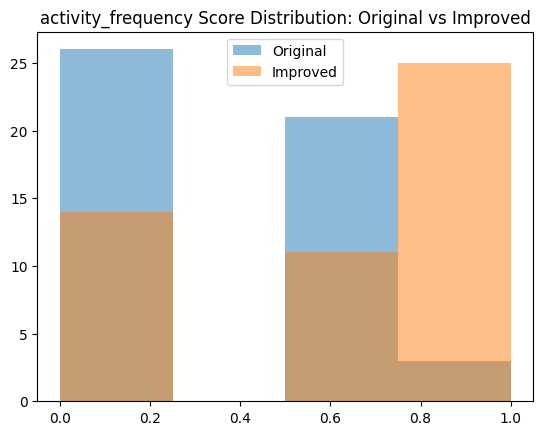

       activity_frequency_before  activity_frequency_after
count                  50.000000                 50.000000
mean                    0.374000                  0.601000
std                     0.216475                  0.305141
min                     0.200000                  0.200000
25%                     0.200000                  0.200000
50%                     0.200000                  0.625000
75%                     0.500000                  0.750000
max                     1.000000                  1.000000


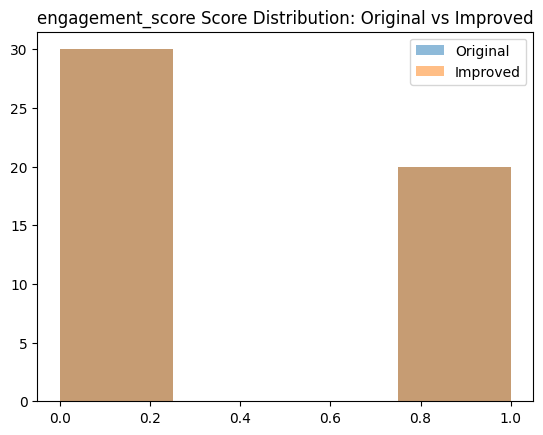

       engagement_score_before  engagement_score_after
count                50.000000               50.000000
mean                  0.520000                0.420000
std                   0.395897                0.272179
min                   0.200000                0.200000
25%                   0.200000                0.200000
50%                   0.200000                0.200000
75%                   1.000000                0.750000
max                   1.000000                0.750000


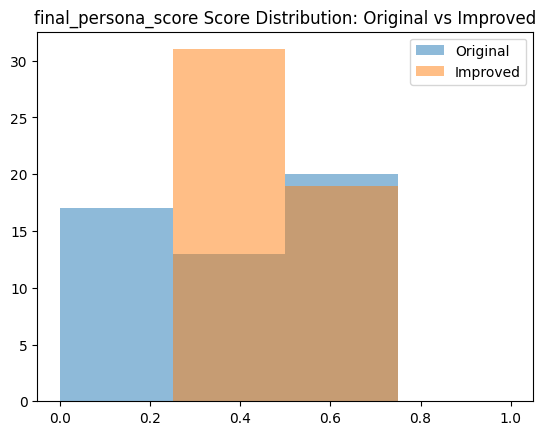

       final_persona_score_before  final_persona_score_after
count                   50.000000                  50.000000
mean                     0.406200                   0.416340
std                      0.218069                   0.124527
min                      0.200000                   0.266000
25%                      0.200000                   0.301000
50%                      0.255000                   0.376000
75%                      0.636000                   0.531250
max                      0.691000                   0.623000


In [108]:
compare_df = df_before.merge(
    result_df,
    on="contact_id",
    suffixes=("_before", "_after")
)

features = ['num_deals', 'sum_deal_amount', 'deal_stages',
            'activity_count', 'activity_frequency', 'engagement_score', 'final_persona_score']

for metric in features:
  min_val = min(df_before[f'{metric}'].min(), result_df[f'{metric}'].min())
  max_val = max(df_before[f'{metric}'].max(), result_df[f'{metric}'].max())
  bins = np.linspace(0, 1, 5)

  plt.hist(df_before[f'{metric}'], bins=bins, alpha=0.5, label='Original')
  plt.hist(result_df[f'{metric}'], bins=bins, alpha=0.5, label='Improved')
  plt.legend()
  plt.title(f"{metric} Score Distribution: Original vs Improved")
  plt.show()

  print(compare_df[[f'{metric}_before', f'{metric}_after']].describe())


## Prediction

In [109]:
def score_new_contact(contact_id, deal_records, activity_records, weights, binning_rules, engagement_weights):
    df_deals = pd.DataFrame(deal_records)
    df_activities = pd.DataFrame(activity_records)

    merged = pd.merge(df_activities, df_deals, on="deal_id")

    deals = group["deal_id"].nunique()
    amount = group.drop_duplicates("deal_id")["deal_amount"].sum()
    stages = group.drop_duplicates("deal_id")["deal_stage"].nunique()
    deal_win_rate = group[group["class_tag"] == "closed won"].shape[0] / group.shape[0] if group.shape[0] > 0 else 0
    activity_count = group.shape[0]

    # Trend-based scores across all activities in the account
    intent_score = compute_trend(group["intent_score"].dropna().tolist())
    sentiment_score = compute_trend(group["sentiment_score"].dropna().tolist())
    emotion_score = compute_trend(group["emotion_score"].dropna().tolist())

    # Sort timestamps and compute avg gap in days
    timestamps = group.sort_values("timestamp")["timestamp"]

    if len(timestamps) > 1:
        gaps = timestamps.diff().dt.days.dropna()
        activity_frequency = gaps.mean()
    else:
        days_since_last = (pd.Timestamp.now() - timestamps.iloc[0]).days
        activity_frequency = days_since_last

    recency = (pd.Timestamp.now() - group["timestamp"].max()).days
    engagement_score = group["activity_type"].map(engagement_weights).sum()

    contact_features = {
        "contact_id": contact_id,
        "num_deals": deals,
        "sum_deal_amount": amount,
        "deal_stages": stages,
        "deal_win_rate": deal_win_rate,
        "activity_count": activity_count,
        "recency": recency,
        "activity_frequency": activity_frequency,
        "engagement_score": engagement_score,
        "intent_score": intent_score,
        "sentiment_score": sentiment_score,
        "emotion_score": emotion_score
    }

    return compute_contact_persona_score(contact_features, weights, binning_rules)

In [111]:
example_deal_records = [
    {"deal_id": "DX1", "contact_id": "C1", "deal_amount": 9000, "deal_stage": "Proposal"},
    {"deal_id": "DX2", "contact_id": "C1", "deal_amount": 14000, "deal_stage": "Won"},
    {"deal_id": "DX3", "contact_id": "C2", "deal_amount": 3000, "deal_stage": "Negotiation"}
]

example_activity_records = [
    {
        "deal_id": "DX1",
        "activity_type": "call",
        "timestamp": datetime.now() - timedelta(days=5),
        "intent": "request",
        "emotion": "neutral",
        "sentiment": "neutral"
    },
    {
        "deal_id": "DX1",
        "activity_type": "mail",
        "timestamp": datetime.now() - timedelta(days=3),
        "intent": "request",
        "emotion": "happy",
        "sentiment": "positive"
    },
    {
        "deal_id": "DX2",
        "activity_type": "meeting",
        "timestamp": datetime.now() - timedelta(days=1),
        "intent": "purchase",
        "emotion": "enthusiasm",
        "sentiment": "positive"
    },
    {
        "deal_id": "DX3",
        "activity_type": "mail",
        "timestamp": datetime.now() - timedelta(days=2),
        "intent": "gratitude",
        "emotion": "neutral",
        "sentiment": "neutral"
    }
]

In [112]:
new_contact_score = score_new_contact("CNew", example_deal_records, example_activity_records, weights, binning_rules, engagement_weights)
print("\nScored new contact:")
print(json.dumps(new_contact_score, indent=2))



Scored new contact:
{
  "contact_id": "CNew",
  "final_persona_score": 0.526,
  "individual_feature_scores": {
    "num_deals": 0.75,
    "sum_deal_amount": 0.2,
    "deal_stages": 0.2,
    "deal_win_rate": 0.2,
    "activity_count": 0.75,
    "recency": 0.75,
    "activity_frequency": 0.5,
    "intent_score": -0.03140350877192982,
    "emotion_score": -0.03421052631578947,
    "sentiment_score": -0.0375438596491228,
    "engagement_score": 0.75
  }
}
